<a href="https://colab.research.google.com/github/umeshtharukaofficial/Flight-Delay-Prediction/blob/main/Flight_Delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flight Delay Prediction: Regression with ML & DL in Google Colab

Project Introduction

Welcome to the Flight Delay Prediction project! Flight delays cause significant inconvenience to passengers, financial losses to airlines, and ripple effects across the air traffic network. Predicting these delays in advance can help airlines optimize operations and improve passenger experience.

The Problem:

We aim to build models that can forecast the total arrival delay (in minutes) for flights. This involves analyzing historical flight data, including carrier performance, airport characteristics, and aggregated delay causes (like weather or air traffic system issues).

The Dataset:

We will use the "Flight Delay Data" dataset from Kaggle (sriharshaeedala/airline-delay). This dataset provides aggregated monthly and yearly information on U.S. flight arrivals and delays, including various delay causes (carrier, weather, National Airspace System (NAS), security, late aircraft). While it doesn't offer per-flight granularity for real-time prediction, it's suitable for demonstrating regression models on aggregated historical trends. The primary target variable will be arr_delay (total arrival delay in minutes).

The Final Output:

By the end of this project, you will have trained and extensively evaluated regression models (XGBoost, LSTM) capable of predicting flight delays. We will utilize a comprehensive suite of regression metrics and visualizations to assess model performance, and explore explainability and breakdown analyses.

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, matthews_corrcoef, precision_recall_curve, log_loss, classification_report
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Flatten, Reshape, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import xgboost as xgb # For XGBoost Regressor
import shap # For SHAP values (model explainability)
from sklearn.inspection import permutation_importance # For Permutation Feature Importance
import random

# Install necessary libraries (if not already present in Colab)
print("--- Installing required libraries ---")
# Use -qq for quiet install to reduce log spam
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy xgboost shap -qq

from IPython.display import clear_output
clear_output() # Clear installation output
print("Required libraries installed and imported.")

# --- 2.1. Verify Uploaded File ---
print("\n--- Verifying Uploaded Dataset File ---")
zip_file_name = 'airline-delay.zip'
extracted_dir = 'flight_data' # Directory to extract data to

print(f"Current working directory: {os.getcwd()}")
print("Files in current directory:")
!ls -lh # List files to confirm the zip file is there and its exact name

if os.path.exists(zip_file_name):
    print(f"SUCCESS: '{zip_file_name}' found in current directory. Proceeding to unzip.")
else:
    print(f"\nFATAL ERROR: '{zip_file_name}' was NOT found in the current directory.")
    print("Please ensure you have manually downloaded the dataset from Kaggle and uploaded it to Colab's session storage.")
    print(f"Make sure the uploaded file is named exactly '{zip_file_name}'.")
    raise FileNotFoundError(f"'{zip_file_name}' not found. Manual download and upload to Colab is required.")


# --- 2.2. Unzip the dataset ---
print("\n--- Unzipping Dataset ---")
# Remove previous extraction if any to ensure clean state
if os.path.exists(extracted_dir):
    !rm -rf {extracted_dir}
    print(f"Removed existing '{extracted_dir}' directory.")
os.makedirs(extracted_dir, exist_ok=True) # Create the directory

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
clear_output() # Clear output after successful unzip
print(f"Dataset unzipped to '{extracted_dir}/'.")

# --- 2.3. Verify contents and set data_file_path ---
print("\n--- Verifying Extracted Dataset Contents ---")
# The zip file contains 'Airline_Delay_Cause.csv' directly inside
data_file_name = 'Airline_Delay_Cause.csv' # FIXED: Changed from 'airline-delay.csv'
data_file_path = os.path.join(extracted_dir, data_file_name)

print(f"Contents of '{extracted_dir}':")
!ls -lh {extracted_dir}

print(f"\nAttempting to load data file at: {data_file_path}")

if os.path.exists(data_file_path):
    print(f"SUCCESS: Data file '{data_file_path}' found.")
else:
    print(f"ERROR: Data file '{data_file_path}' not found. Please check dataset structure after unzipping.")
    print("Verify the exact file names and paths by looking at the 'ls -lh' outputs above.")
    raise FileNotFoundError(f"Expected data file '{data_file_path}' not found.")


Dataset unzipped to 'flight_data/'.

--- Verifying Extracted Dataset Contents ---
Contents of 'flight_data':
total 28M
-rw-r--r-- 1 root root 28M Jun  8 07:39 Airline_Delay_Cause.csv

Attempting to load data file at: flight_data/Airline_Delay_Cause.csv
SUCCESS: Data file 'flight_data/Airline_Delay_Cause.csv' found.



First 5 rows of the dataset:
   year  month carrier       carrier_name airport  \
0  2023      8      9E  Endeavor Air Inc.     ABE   
1  2023      8      9E  Endeavor Air Inc.     ABY   
2  2023      8      9E  Endeavor Air Inc.     AEX   
3  2023      8      9E  Endeavor Air Inc.     AGS   
4  2023      8      9E  Endeavor Air Inc.     ALB   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         89.0       13.0   
1             Albany, GA: Southwest Georgia Regional         62.0       10.0   
2           Alexandria, LA: Alexandria International         62.0       10.0   
3        Augusta, GA: Augusta Regional at Bush Field         66.0       12.0   
4                   Albany, NY: Albany International         92.0       22.0   

   carrier_ct  weather_ct  ...  security_ct  late_aircraft_ct  arr_cancelled  \
0        2.25        1.60  ...          0.0              5.99            2.0   
1        1

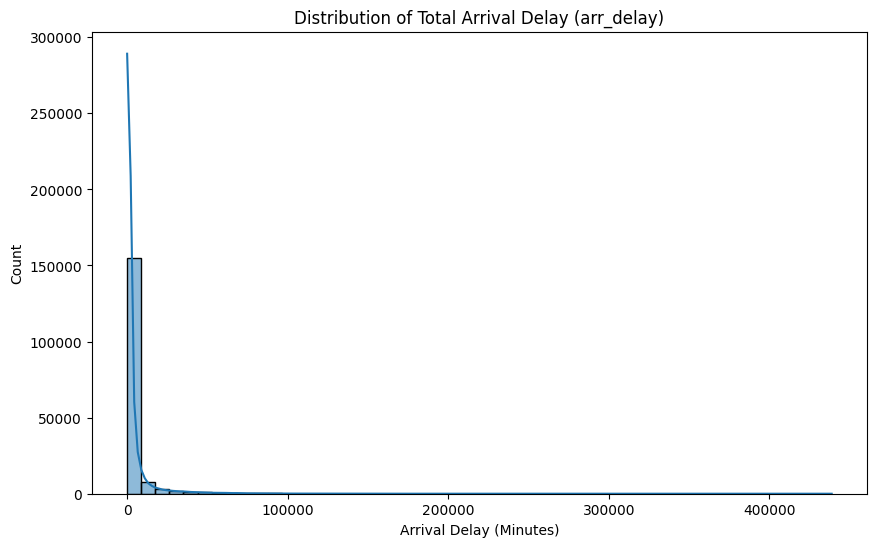


Missing values per column:
year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            240
arr_del15              443
carrier_ct             240
weather_ct             240
nas_ct                 240
security_ct            240
late_aircraft_ct       240
arr_cancelled          240
arr_diverted           240
arr_delay              240
carrier_delay          240
weather_delay          240
nas_delay              240
security_delay         240
late_aircraft_delay    240
dtype: int64


In [ ]:
# Load the CSV file
data_file_name = 'Airline_Delay_Cause.csv' # Ensure this matches the extracted name
data_file_path = os.path.join('flight_data', data_file_name) # Assuming it's in the 'flight_data' folder

try:
    # --- Check if file exists and is not empty ---
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"The data file '{data_file_path}' was not found after unzipping. Please check the output of Section 2.3 carefully.")
    if os.path.getsize(data_file_path) == 0:
        raise ValueError(f"The data file '{data_file_path}' is empty. Please ensure the dataset downloaded correctly.")

    # Load the CSV file
    # Use default separator (comma) as it's a CSV.
    df = pd.read_csv(data_file_path)

    # --- Basic DataFrame validation after loading ---
    if df.empty:
        raise ValueError(f"DataFrame is empty after loading '{data_file_path}'. The CSV might be malformed or empty of actual data rows.")
    if 'arr_delay' not in df.columns:
        raise ValueError(f"Required column 'arr_delay' not found in the dataset. Available columns: {df.columns.tolist()}")

    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    df.info()

    print("\nDataFrame Columns:")
    print(df.columns)

    # Check distribution of the target variable 'arr_delay'
    print("\nDescription of 'arr_delay' (Total Arrival Delay in Minutes):")
    print(df['arr_delay'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df['arr_delay'], bins=50, kde=True)
    plt.title('Distribution of Total Arrival Delay (arr_delay)')
    plt.xlabel('Arrival Delay (Minutes)')
    plt.ylabel('Count')
    plt.show()

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

except Exception as e:
    print(f"Error loading or processing CSV: {e}")
    print("Please ensure the CSV file format matches expectations and 'Airline_Delay_Cause.csv' is correct.")
    # Re-raise the exception to stop execution if data loading failed
    raise

In [ ]:
# --- 4.1. Handle Missing Values ---
# For aggregated counts, NaN might imply 0. We'll fill NaNs with 0 for relevant columns.
# Or, drop rows if missing values are significant and cannot be imputed.
# Based on df.isnull().sum(), most columns have 0 NaNs, but `weather_ct` etc. might.
# For simplicity, fill all numerical features with 0 if NaN, as it likely means 0 delays of that type.
df_processed = df.copy()
numerical_cols = df_processed.select_dtypes(include=np.number).columns.tolist()
# Exclude 'arr_delay' from being filled with 0 if it's the target, as it's the value to predict.
# However, this dataset explicitly lists all delay causes as numerical. So, fill NaNs.
for col in numerical_cols:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(0, inplace=True)
        print(f"Filled NaN in '{col}' with 0.")

# Drop redundant name columns
df_processed = df_processed.drop(columns=['carrier_name', 'airport_name'], errors='ignore')

# --- 4.2. Feature Engineering ---
# This dataset is already aggregated. We can create simple interaction features or ratios.
# Example: ratio of delayed flights to total flights
df_processed['delay_ratio'] = df_processed['arr_del15'] / df_processed['arr_flights']
df_processed['delay_ratio'].fillna(0, inplace=True) # Handle division by zero if arr_flights is 0

# Time-based features (year and month are already present)
# For monthly aggregates, we can't create hourly features.
# 'year' and 'month' can be used directly or transformed (e.g., sin/cos for month seasonality).
# For simplicity, we'll use them directly.

# --- 4.3. Handle Categorical Features (One-Hot Encoding) ---
# 'carrier' and 'airport' are categorical. One-hot encode them.
# Be aware: 'airport' has many unique values, which can lead to a very wide DataFrame.
# For small dataset, it might be okay, but for larger, consider PCA on one-hot or target encoding.

print(f"\nUnique carriers: {df_processed['carrier'].nunique()}")
print(f"Unique airports: {df_processed['airport'].nunique()}")

# If too many unique values for airport, we might only one-hot encode top N or use LabelEncoder
# For this guide, we'll one-hot encode, but note the potential for high dimensionality.
categorical_features = ['carrier', 'airport']
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True) # drop_first to avoid multicollinearity

print(f"\nShape of DataFrame after one-hot encoding: {df_encoded.shape}")
print(f"First 5 rows after encoding: {df_encoded.head()}")


# --- 4.4. Define Features (X) and Target (y) ---
# The target variable is 'arr_delay'.
# Features are all other columns. We must drop the original 'arr_delay' from X.
target_column = 'arr_delay'
if target_column not in df_encoded.columns:
    raise ValueError(f"Target column '{target_column}' not found in DataFrame.")

X = df_encoded.drop(columns=[target_column])
y = df_encoded[target_column]

# Review features to ensure no leakage from delay components if not intended
# Columns like 'carrier_delay', 'weather_delay' etc. are components of 'arr_delay'.
# Using them as features implies you know the 'cause' of the delay *before* predicting the total delay,
# which might not be realistic for true *prediction*.
# For this guide, we'll keep them as features to show their impact, but in a real-world scenario,
# you'd only use features known *before* the flight departs/arrives.
print("\nSelected features for X:")
print(X.columns.tolist())


# --- 4.5. Scale Numerical Features ---
# Scaling is crucial for some models (e.g., LSTMs, Neural Networks).
# For XGBoost, it's less critical but can sometimes help.
scaler = StandardScaler()
# Exclude one-hot encoded columns from scaling, as they are binary (0/1)
# Identify numerical columns that are not one-hot encoded
numerical_cols_to_scale = [col for col in X.columns if col not in df_encoded.columns or df_encoded[col].nunique() > 2]
# Filter out year/month if you don't want to scale them (often they are treated as categorical or time features)
# For simplicity, we'll scale all non-binary numerical columns.
# Let's get the original numerical columns first, excluding the target and original categorical.
original_numerical_features = [col for col in numerical_cols if col not in categorical_features + [target_column]]

# Get the names of the one-hot encoded columns
one_hot_encoded_cols = [col for col in X.columns if col.startswith(tuple(categorical_features))]

# Actual numerical columns to scale are original_numerical_features
X_numerical = X[original_numerical_features]
X_categorical_encoded = X[one_hot_encoded_cols] # These are already 0/1 dummies.

X_scaled = scaler.fit_transform(X_numerical)
X_scaled_df = pd.DataFrame(X_scaled, columns=original_numerical_features, index=X.index)

# Recombine scaled numerical and one-hot encoded categorical features
X_final = pd.concat([X_scaled_df, X_categorical_encoded], axis=1)

print(f"\nShape of final feature matrix (X_final): {X_final.shape}")
print(f"First 5 rows of final feature matrix: {X_final.head()}")

# --- 4.6. Train/Test Split ---
print("\n--- Performing Train/Test Split ---")
# Use X_final for features, y for target
X_train_final, X_test_final, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(f"Training features shape (X_train_final): {X_train_final.shape}")
print(f"Test features shape (X_test_final): {X_test_final.shape}")
print(f"Training target shape (y_train): {y_train.shape}")
print(f"Test target shape (y_test): {y_test.shape}")


<ipython-input-4-27868cad3882>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(0, inplace=True)
<ipython-input-4-27868cad3882>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

Filled NaN in 'arr_flights' with 0.
Filled NaN in 'arr_del15' with 0.
Filled NaN in 'carrier_ct' with 0.
Filled NaN in 'weather_ct' with 0.
Filled NaN in 'nas_ct' with 0.
Filled NaN in 'security_ct' with 0.
Filled NaN in 'late_aircraft_ct' with 0.
Filled NaN in 'arr_cancelled' with 0.
Filled NaN in 'arr_diverted' with 0.
Filled NaN in 'arr_delay' with 0.
Filled NaN in 'carrier_delay' with 0.
Filled NaN in 'weather_delay' with 0.
Filled NaN in 'nas_delay' with 0.
Filled NaN in 'security_delay' with 0.
Filled NaN in 'late_aircraft_delay' with 0.

Unique carriers: 21
Unique airports: 395

Shape of DataFrame after one-hot encoding: (171666, 432)
First 5 rows after encoding:    year  month  arr_flights  arr_del15  carrier_ct  weather_ct  nas_ct  \
0  2023      8         89.0       13.0        2.25        1.60    3.16   
1  2023      8         62.0       10.0        1.97        0.04    0.57   
2  2023      8         62.0       10.0        2.73        1.18    1.80   
3  2023      8         66

In [ ]:
print("\n--- Building and Training XGBoost Regressor ---")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # For regression
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=5,                  # Maximum depth of a tree
    subsample=0.8,                # Subsample ratio of the training instance
    colsample_bytree=0.8,         # Subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1                     # Use all available cores
)

# Explicitly convert y_train to a Series using .squeeze()
# This helps ensure XGBoost receives the target in the expected format (Series)
y_train_series = y_train.squeeze()

# Convert the feature DataFrame to a NumPy array to avoid potential pandas/xgboost interaction issues
X_train_array = X_train_final.values

# Fit the model using the NumPy array for features and the Series for the target
xgb_model.fit(X_train_array, y_train_series)

print("\nXGBoost Regressor training finished.")


--- Building and Training XGBoost Regressor ---

XGBoost Regressor training finished.


In [ ]:
from tensorflow.keras.models import load_model # For loading models if needed
import numpy as np # Ensure numpy is imported

print("\n--- Building and Training LSTM Model ---")

# LSTM expects 3D input: (samples, timesteps, features)
# Here, each row is a sample, and we have only 1 timestep, with all features as input.
# So we need to reshape X_train_final and X_test_final.
X_train_lstm = X_train_final.values.reshape(X_train_final.shape[0], 1, X_train_final.shape[1])
X_test_lstm = X_test_final.values.reshape(X_test_final.shape[0], 1, X_test_final.shape[1])

# Convert features to float32, which is commonly preferred by TensorFlow/Keras
X_train_lstm = X_train_lstm.astype(np.float32)
X_test_lstm = X_test_lstm.astype(np.float32)


print(f"Reshaped X_train_lstm shape: {X_train_lstm.shape}")
print(f"Reshaped X_test_lstm shape: {X_test_lstm.shape}")
print(f"X_train_lstm dtype: {X_train_lstm.dtype}") # Print dtypes to verify
print(f"X_test_lstm dtype: {X_test_lstm.dtype}")


def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape), # Input shape (timesteps, features) -> (1, num_features)
        LSTM(100, activation='relu', return_sequences=False), # return_sequences=False for single output
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1) # Output layer for regression (single delay value)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) # MSE for loss, MAE for metric
    return model

lstm_model = build_lstm_model(X_train_lstm.shape[1:])
lstm_model.summary()

# Define callbacks for training
callbacks_lstm = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True, monitor='val_mae'),
    ModelCheckpoint('best_lstm_flight_delay_predictor.keras', save_best_only=True, monitor='val_mae', mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

print("\n--- Training LSTM Model ---")

# Convert y_train to a NumPy array and cast to float32
y_train_array = y_train.values.astype(np.float32)
y_test_array = y_test.values.astype(np.float32) # Also convert test target for consistency/future evaluation

print(f"y_train_array shape: {y_train_array.shape}")
print(f"y_train_array dtype: {y_train_array.dtype}")


history_lstm = lstm_model.fit(X_train_lstm, y_train_array, # Use the NumPy array for training
                              epochs=100, # Increased epochs for deep learning
                              batch_size=32,
                              validation_split=0.1, # Use a validation split from training data
                              callbacks=callbacks_lstm,
                              verbose=1)

print("\nLSTM Model training finished.")


--- Building and Training LSTM Model ---
Reshaped X_train_lstm shape: (137332, 1, 432)
Reshaped X_test_lstm shape: (34334, 1, 432)
X_train_lstm dtype: float32
X_test_lstm dtype: float32


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │       213,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,301 (852.74 KB)

 Trainable params: 218,301 (852.74 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
y_train_array shape: (137332,)
y_train_array dtype: float32
Epoch 1/100
3860/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 37775820.0000 - mae: 1645.9623
Epoch 1: val_mae improved from inf to 1267.57031, saving model to best_lstm_flight_delay_predictor.keras
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - loss: 37763364.0000 - mae: 1645.7664 - val_loss: 18541548.0000 - val_mae: 1267.5703 - learning_rate: 0.0010
Epoch 2/100
3861/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20882614.0000 - mae: 1360.1917
Epoch 2: val_mae improved from 1267.57031 to 1263.09106, saving model to best_lstm_flight_delay_predictor.keras
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 20883300.0000 - mae: 1360.1931 - val_loss: 17736840.0000 - val_mae: 1263.0911 - learning_rate: 0.0010
Epoch 3/100
3858/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19039642.0000 - mae: 1302.4232
Epoch 3: val_mae improved from 1263.09106 to 1226.31274, saving model to best_lstm_flight_delay_predicto


--- Making Predictions on Test Data ---
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Predictions completed.

--- Metrics for XGBoost ---
Mean Absolute Error (MAE): 283.5089
Mean Squared Error (MSE): 3191722.6601
Root Mean Squared Error (RMSE): 1786.5393
R² Score: 0.9804
Mean Absolute Percentage Error (MAPE, excluding 0 true values): 25.0973%

--- Metrics for LSTM ---
Mean Absolute Error (MAE): 385.7636
Mean Squared Error (MSE): 1443008.0941
Root Mean Squared Error (RMSE): 1201.2527
R² Score: 0.9911
Mean Absolute Percentage Error (MAPE, excluding 0 true values): 33.6944%

--- Consolidated Model Performance Metrics on Test Set ---
              MAE           MSE       RMSE  R2 Score     MAPE
XGBoost  283.5089  3.191723e+06  1786.5393    0.9804  25.0973
LSTM     385.7636  1.443008e+06  1201.2527    0.9911  33.6944


<ipython-input-7-d43c213344f7>:28: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true_np - y_pred) / y_true_np)) * 100
<ipython-input-7-d43c213344f7>:28: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true_np - y_pred) / y_true_np)) * 100


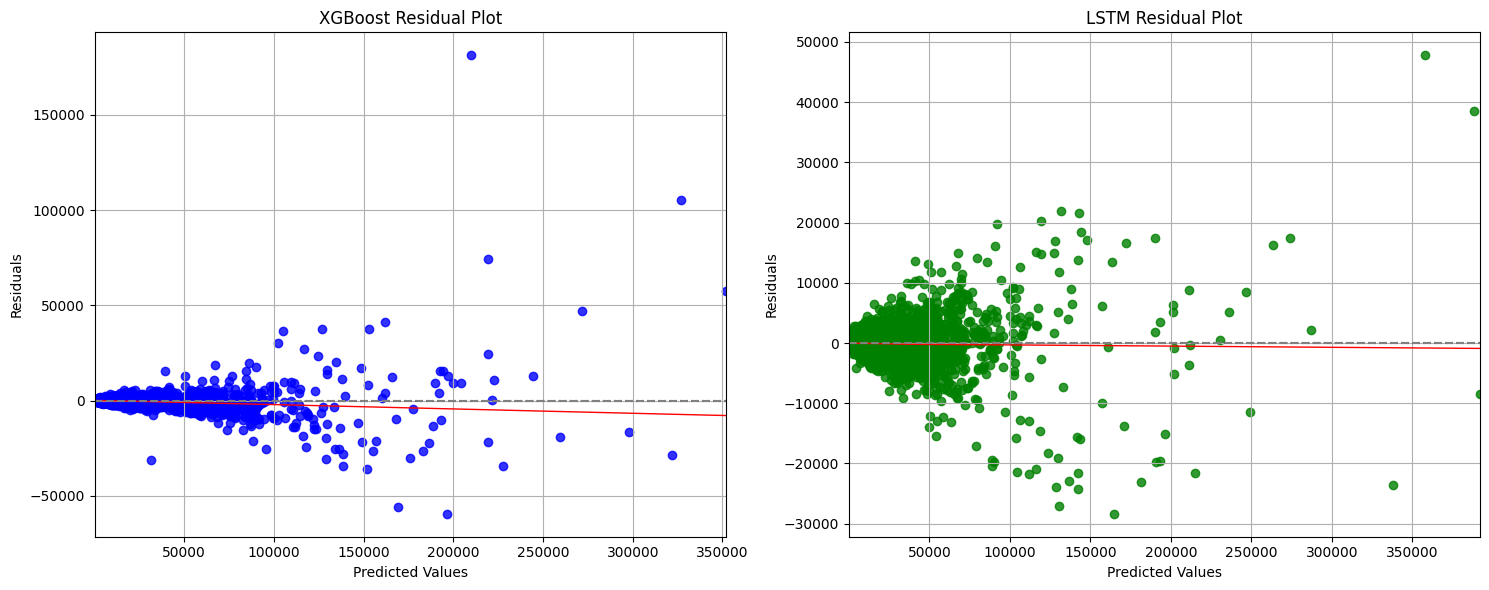

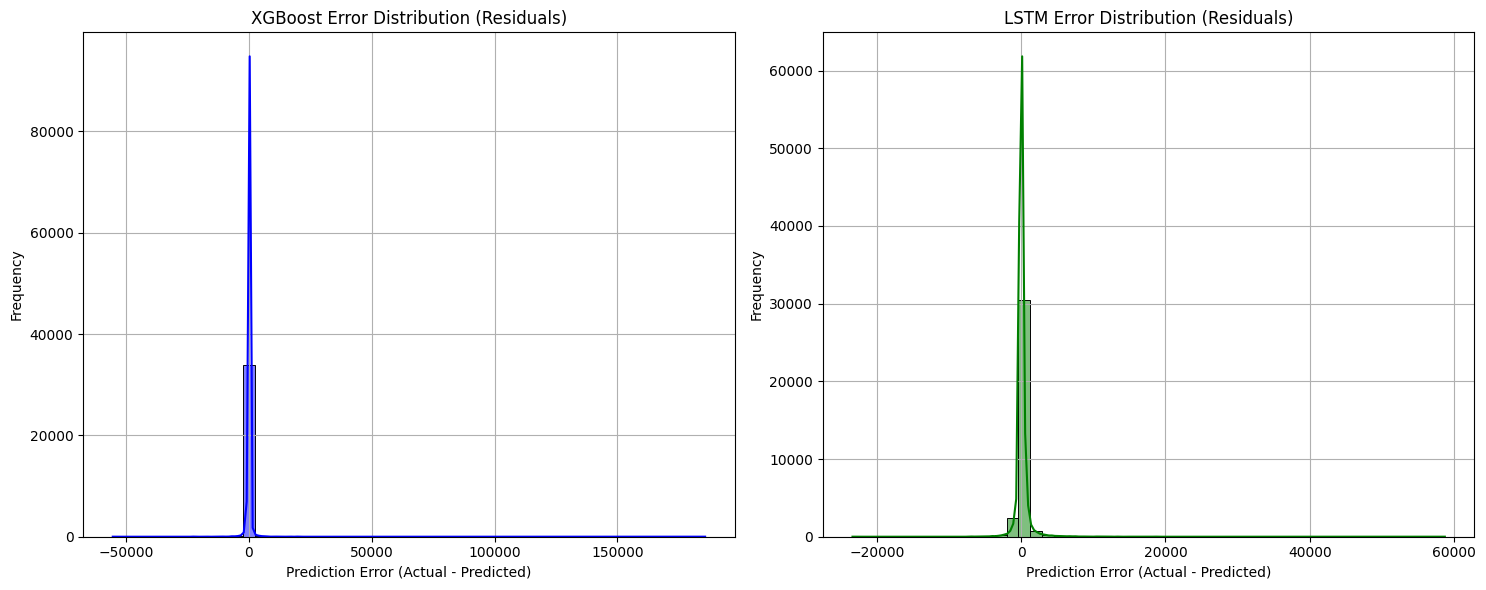

<ipython-input-7-d43c213344f7>:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red') # Ideal line
<ipython-input-7-d43c213344f7>:114: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red') # Ideal line


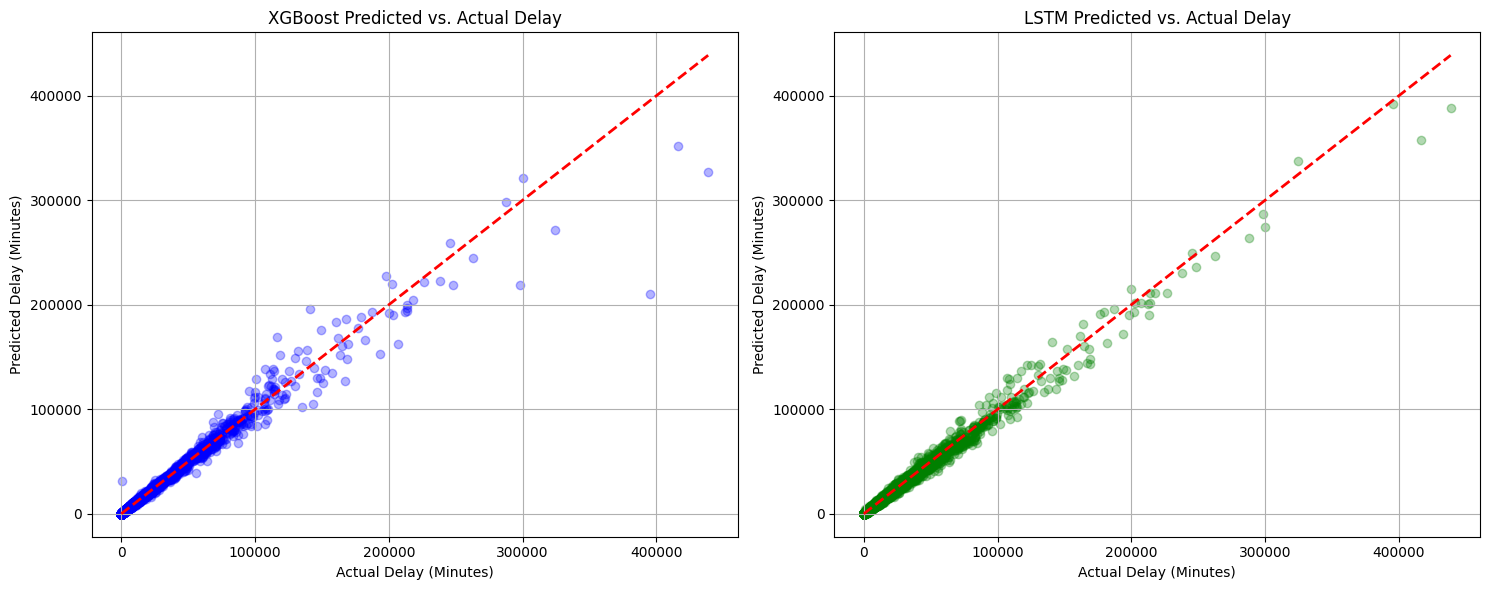


--- XGBoost Feature Importance ---
arr_del15              0.545686
late_aircraft_delay    0.184481
carrier_delay          0.065358
carrier_delay          0.035087
weather_ct             0.025890
nas_delay              0.018195
weather_delay          0.013249
carrier_WN             0.011801
airport_ATL            0.011449
nas_ct                 0.010981
dtype: float32


<ipython-input-7-d43c213344f7>:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_feature_importance.head(10).values, y=xgb_feature_importance.head(10).index, palette='viridis')


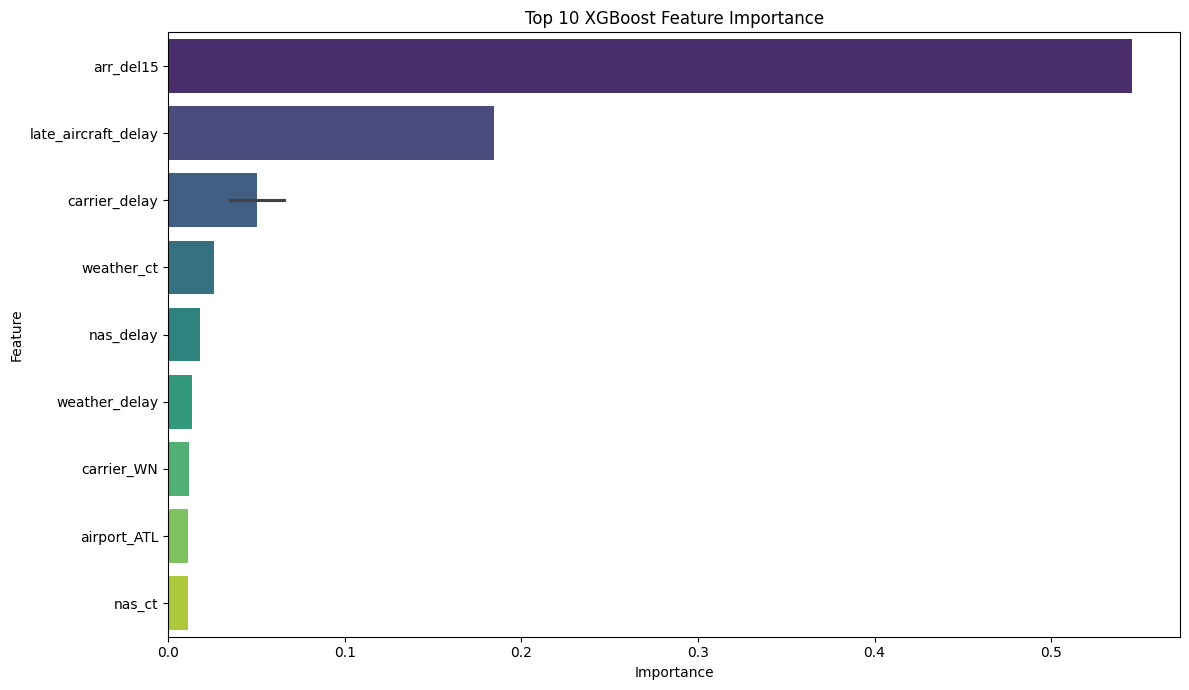


--- Permutation Feature Importance (for XGBoost) ---
arr_del15              0.342580
late_aircraft_delay    0.150131
carrier_delay          0.054639
nas_delay              0.043555
late_aircraft_ct       0.019620
weather_delay          0.017390
year                   0.010412
arr_diverted           0.007737
carrier_delay          0.007397
weather_ct             0.005554
dtype: float64


<ipython-input-7-d43c213344f7>:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_feature_importance.head(10).values, y=perm_feature_importance.head(10).index, palette='magma')


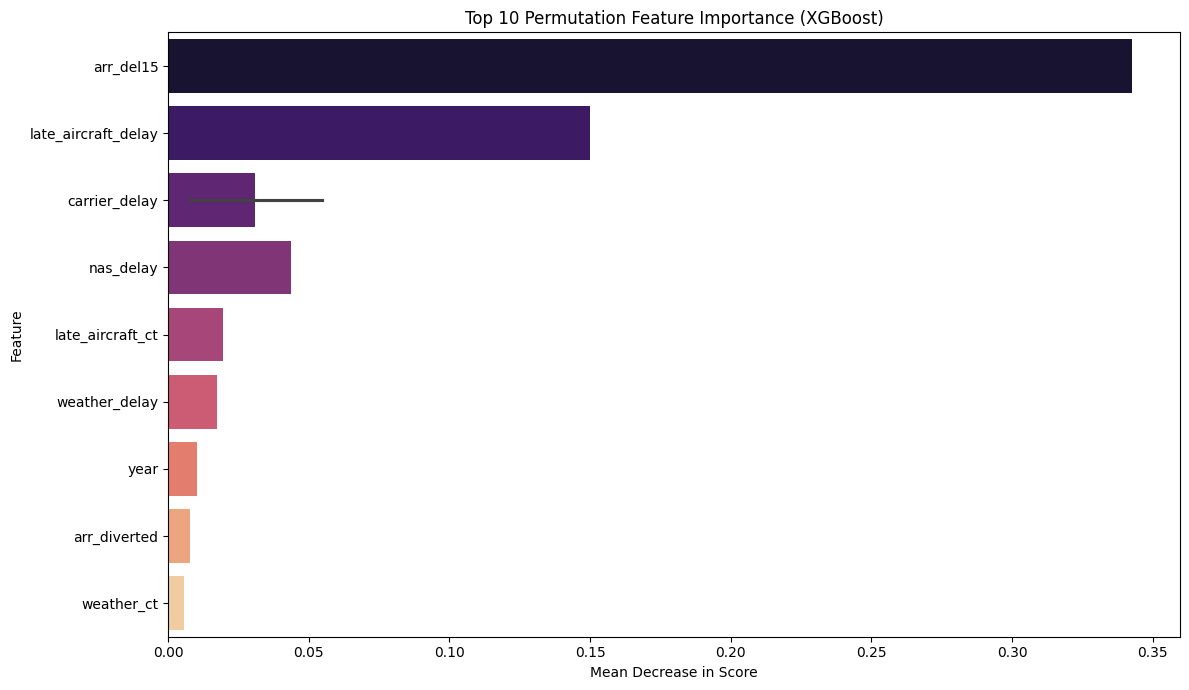


--- SHAP Values (Model Explainability for XGBoost) ---

SHAP Summary Plot (Beeswarm) - Feature Impact on Model Output:


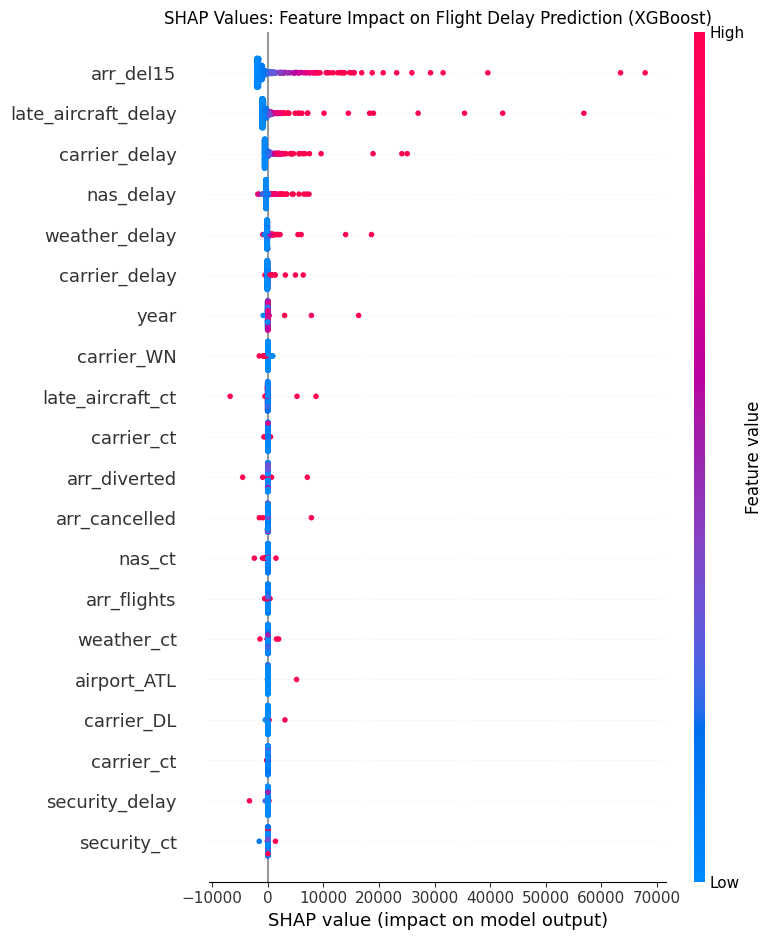


SHAP Dependence Plots for Top Features:


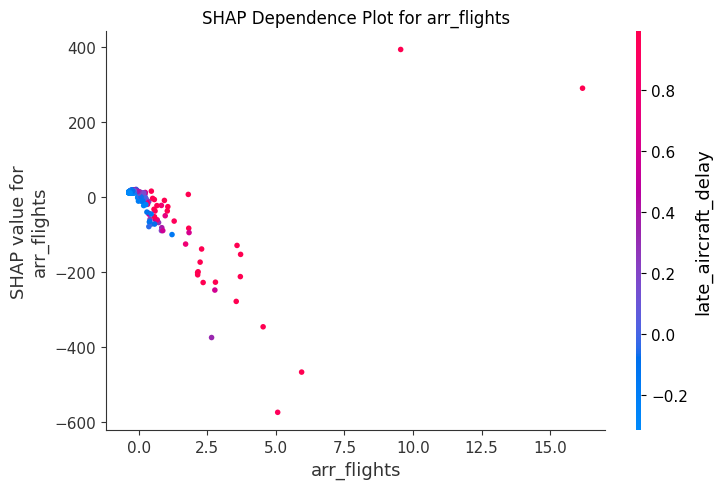

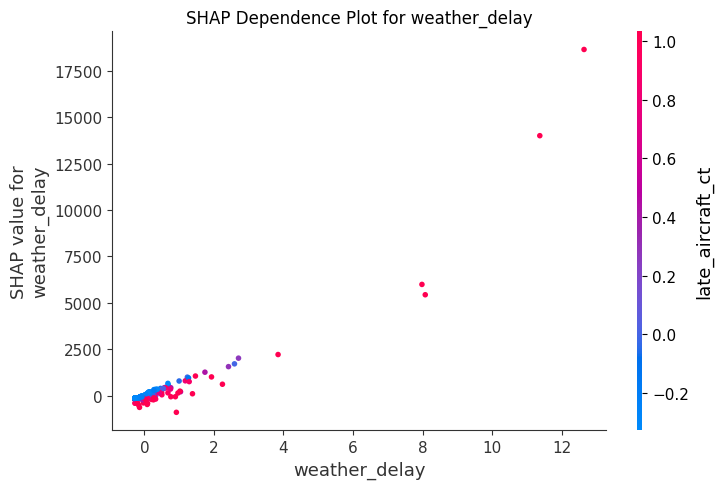


--- Airport-Wise Prediction Error Analysis ---


<ipython-input-7-d43c213344f7>:212: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  airport_errors_xgb = X_test_original_df.groupby('airport').apply(lambda x: pd.Series({
<ipython-input-7-d43c213344f7>:217: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  airport_errors_lstm = X_test_original_df.groupby('airport').apply(lambda x: pd.Series({
<ipython-input-7-d43c213344f7>:235: FutureWarning: 

Passing `palette` 


Top 10 Airports with Highest MAE (XGBoost):
                 MAE          RMSE  Count
airport                                  
DFW      2759.283096  10261.568124  237.0
ATL      2262.548399  12604.476479  309.0
ORD      2020.371693   5127.812334  292.0
MDW      1350.080148   6267.757382   97.0
EWR      1195.073905   3491.415502  270.0
SFO      1115.156333   2352.205443  249.0
DEN      1096.122831   3202.300969  249.0
SUN      1081.624966   5535.011584   31.0
CLT       881.946156   3018.652737  281.0
JFK       872.357847   1996.263645  178.0

Top 10 Airports with Lowest MAE (XGBoost):
               MAE       RMSE  Count
airport                             
FLO      21.305443  27.187738    2.0
CDB      26.525505  29.995112    4.0
FOE      30.784668  30.784668    1.0
LMT      34.755371  46.047847    2.0
IFP      36.151413  43.933409    2.0
AKN      36.194784  45.478627   12.0
SHR      40.821163  43.277479    4.0
HYA      40.950747  45.881288    6.0
BET      42.698869  55.086828   22.0


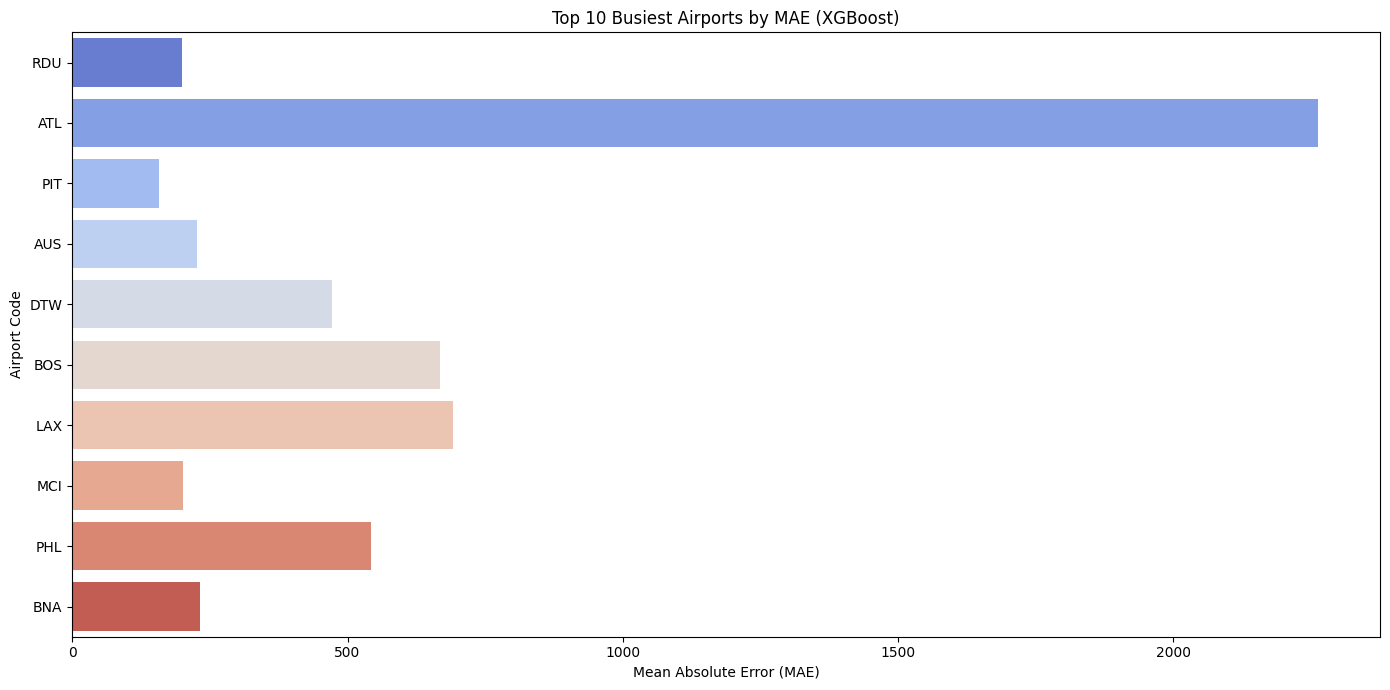


--- Airline-Wise Prediction Error Analysis ---

Top 5 Airlines by MAE (XGBoost):
                MAE         RMSE   Count
carrier                                 
AA       615.199853  3575.900291  2385.0
WN       548.628415  1855.426113  2250.0
DL       398.057981  3871.145845  3348.0
B6       348.033090  1394.103839  1503.0
UA       344.096076  1616.698828  2233.0

--- Weather Impact Correlation Heatmap ---


<ipython-input-7-d43c213344f7>:250: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  airline_errors_xgb = X_test_original_df.groupby('carrier').apply(lambda x: pd.Series({


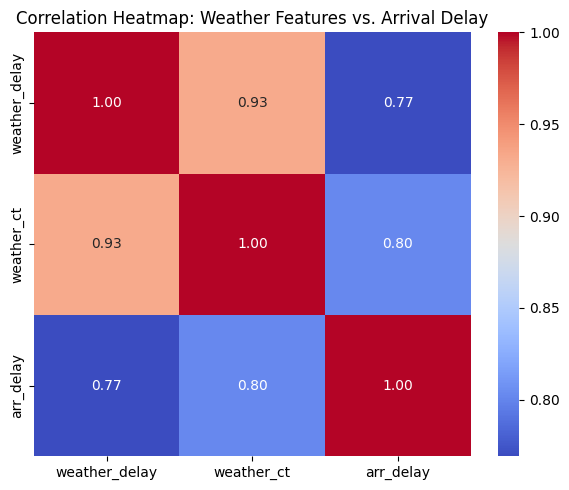


--- Hourly Delay Prediction Performance (Conceptual) ---
Note: This dataset is aggregated monthly/yearly. Direct hourly delay prediction is not possible.
For hourly performance, you would need a dataset with 'DepTime', 'ArrTime', 'CRS_DEP_TIME', etc., and then:
1. Create time-of-day features (e.g., hour of departure/arrival, time blocks).
2. Evaluate MAE/RMSE broken down by hour of day.
3. Analyze if certain hours are harder to predict.

--- Lift Charts and Calibration Curve (Conceptual for Regression) ---
Lift charts and calibration curves are more common for classification problems.
For regression, their application is typically conceptualized by binning the predicted/actual delays:
1. **Lift Chart for Regression:** (Conceptual) Sort test samples by predicted delay. Divide into deciles. Calculate the average actual delay in each decile vs. the overall average actual delay. This shows how much 'lift' you get by targeting higher predicted delays.
2. **Calibration Curve for Regression:

In [ ]:
# --- 6.1. Make Predictions ---
print("\n--- Making Predictions on Test Data ---")

# Convert the feature DataFrame to a NumPy array for prediction
X_test_array = X_test_final.values

# XGBoost Predictions
y_pred_xgb = xgb_model.predict(X_test_array) # Use the NumPy array for prediction

# LSTM Predictions (needs reshaped test data)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten() # Flatten to 1D array

print("Predictions completed.")

# --- 6.2. Evaluate Comprehensive Regression Metrics ---

# Function to calculate regression metrics
def calculate_regression_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero for y_true == 0
    # Ensure y_true is a numpy array for boolean indexing
    y_true_np = np.asarray(y_true)
    mape = np.mean(np.abs((y_true_np - y_pred) / y_true_np)) * 100
    mape_clean = np.mean(np.abs((y_true_np[y_true_np != 0] - y_pred[y_true_np != 0]) / y_true_np[y_true_np != 0])) * 100

    print(f"\n--- Metrics for {model_name} ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE, excluding 0 true values): {mape_clean:.4f}%")

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'MAPE': mape_clean # Use clean MAPE for comparison
    }

metrics_summary = {}
# Pass y_test as is (Pandas Series or np array is fine here) and y_pred
metrics_summary['XGBoost'] = calculate_regression_metrics(y_test, y_pred_xgb, 'XGBoost')
metrics_summary['LSTM'] = calculate_regression_metrics(y_test, y_pred_lstm, 'LSTM')

# Display consolidated metrics in a DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_summary, orient='index')
print("\n--- Consolidated Model Performance Metrics on Test Set ---")
print(metrics_df.round(4))

# --- 6.3. Visualizations for Regression Performance ---

# Residual Plots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
# Pass y_test (Series/array) and y_pred_xgb (array)
sns.residplot(x=y_pred_xgb, y=y_test, lowess=True, color="blue", line_kws={'color': 'red', 'lw': 1})
plt.title('XGBoost Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True)

plt.subplot(1, 2, 2)
# Pass y_test (Series/array) and y_pred_lstm (array)
sns.residplot(x=y_pred_lstm, y=y_test, lowess=True, color="green", line_kws={'color': 'red', 'lw': 1})
plt.title('LSTM Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

# Error Distribution Histograms (Residuals)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
# y_test - y_pred_xgb works correctly with Series/array subtraction
sns.histplot(y_test - y_pred_xgb, bins=50, kde=True, color='blue')
plt.title('XGBoost Error Distribution (Residuals)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
# y_test - y_pred_lstm works correctly with Series/array subtraction
sns.histplot(y_test - y_pred_lstm, bins=50, kde=True, color='green')
plt.title('LSTM Error Distribution (Residuals)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs Actual Scatter Plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
# Pass y_test (Series/array) and y_pred_xgb (array)
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red') # Ideal line
plt.title('XGBoost Predicted vs. Actual Delay')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.grid(True)

plt.subplot(1, 2, 2)
# Pass y_test (Series/array) and y_pred_lstm (array)
plt.scatter(y_test, y_pred_lstm, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red') # Ideal line
plt.title('LSTM Predicted vs. Actual Delay')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6.4. Feature Importance (for XGBoost) ---
print("\n--- XGBoost Feature Importance ---")
# XGBoost has built-in feature importance
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
print(xgb_feature_importance.head(10)) # Print top 10

plt.figure(figsize=(12, 7))
sns.barplot(x=xgb_feature_importance.head(10).values, y=xgb_feature_importance.head(10).index, palette='viridis')
plt.title('Top 10 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 6.5. Permutation Feature Importance ---
# More robust, model-agnostic feature importance. Can be computationally expensive.
print("\n--- Permutation Feature Importance (for XGBoost) ---")
# Using a subset for faster computation if dataset is large
# Permutation importance can work directly with the DataFrame X_test_final and Series y_test

# Convert the test DataFrame to a NumPy array for permutation_importance
X_test_array_for_perm = X_test_final.values

# Pass the NumPy array to permutation_importance
perm_importance_results = permutation_importance(xgb_model, X_test_array_for_perm, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_feature_importance = pd.Series(perm_importance_results.importances_mean, index=X_test_final.columns).sort_values(ascending=False)
print(perm_feature_importance.head(10))

plt.figure(figsize=(12, 7))
sns.barplot(x=perm_feature_importance.head(10).values, y=perm_feature_importance.head(10).index, palette='magma')
plt.title('Top 10 Permutation Feature Importance (XGBoost)')
plt.xlabel('Mean Decrease in Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 6.6. SHAP Values (Model Explainability for XGBoost) ---
# SHAP (SHapley Additive exPlanations) values explain the contribution of each feature to a prediction.
print("\n--- SHAP Values (Model Explainability for XGBoost) ---")
# Use a subset of the test data for SHAP computation, as it can be slow
subset_for_shap = X_test_final.sample(n=min(500, len(X_test_final)), random_state=42) # Sample up to 500 rows

explainer = shap.TreeExplainer(xgb_model)
# SHAP values should also be computed on the subset DataFrame

# Convert the subset DataFrame to a NumPy array before passing to shap_values
subset_for_shap_array = subset_for_shap.values

# Compute SHAP values using the NumPy array
shap_values = explainer.shap_values(subset_for_shap_array)

# Summary plot (beeswarm plot is very informative)
print("\nSHAP Summary Plot (Beeswarm) - Feature Impact on Model Output:")
# The summary_plot function expects the original data (subset_for_shap DataFrame) and the shap values
# Pass the original DataFrame subset_for_shap here for correct plotting labels and structure
shap.summary_plot(shap_values, subset_for_shap, plot_type="dot", show=False)
plt.title('SHAP Values: Feature Impact on Flight Delay Prediction (XGBoost)')
plt.tight_layout()
plt.show()

# Dependence plots for a couple of important features
print("\nSHAP Dependence Plots for Top Features:")
# Ensure the feature name exists in the subset DataFrame columns
# Pass the original DataFrame subset_for_shap to dependence_plot
if "arr_flights" in subset_for_shap.columns:
    shap.dependence_plot("arr_flights", shap_values, subset_for_shap, show=False)
    plt.title('SHAP Dependence Plot for arr_flights') # Add title
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'arr_flights' not in SHAP subset columns. Skipping dependence plot.")

if "weather_delay" in subset_for_shap.columns:
    shap.dependence_plot("weather_delay", shap_values, subset_for_shap, show=False)
    plt.title('SHAP Dependence Plot for weather_delay') # Add title
    plt.tight_layout()
    plt.show()
else:
     print("Warning: 'weather_delay' not in SHAP subset columns. Skipping dependence plot.")

# --- 6.7. Airport-Wise Delay Accuracy Breakdown ---
print("\n--- Airport-Wise Prediction Error Analysis ---")
# Add predictions back to the original df for breakdown
# Ensure df_processed has 'airport' column and its index matches X_test_final
# Need original airport names from df_processed aligned with X_test_final and y_test
X_test_original_df = df_processed.loc[X_test_final.index, ['airport', 'arr_delay']].copy() # .copy() to avoid SettingWithCopyWarning
X_test_original_df['predicted_delay_xgb'] = y_pred_xgb
X_test_original_df['predicted_delay_lstm'] = y_pred_lstm

# Calculate errors per airport
airport_errors_xgb = X_test_original_df.groupby('airport').apply(lambda x: pd.Series({
    'MAE': mean_absolute_error(x['arr_delay'], x['predicted_delay_xgb']),
    'RMSE': np.sqrt(mean_squared_error(x['arr_delay'], x['predicted_delay_xgb'])),
    'Count': len(x)
}))
airport_errors_lstm = X_test_original_df.groupby('airport').apply(lambda x: pd.Series({
    'MAE': mean_absolute_error(x['arr_delay'], x['predicted_delay_lstm']),
    'RMSE': np.sqrt(mean_squared_error(x['arr_delay'], x['predicted_delay_lstm'])),
    'Count': len(x)
}))

# Display top/bottom airports by MAE (XGBoost example)
print("\nTop 10 Airports with Highest MAE (XGBoost):")
print(airport_errors_xgb.sort_values(by='MAE', ascending=False).head(10))

print("\nTop 10 Airports with Lowest MAE (XGBoost):")
print(airport_errors_xgb.sort_values(by='MAE', ascending=True).head(10))

# Visualizing airport-wise MAE (for top N airports by count)
top_airports = airport_errors_xgb.sort_values(by='Count', ascending=False).head(10).index
# Filter airport_errors_xgb to include only top_airports before plotting
top_airports_errors_xgb = airport_errors_xgb.loc[top_airports]
plt.figure(figsize=(14, 7))
sns.barplot(x=top_airports_errors_xgb['MAE'], y=top_airports_errors_xgb.index, palette='coolwarm') # Use .index for airport codes
plt.title('Top 10 Busiest Airports by MAE (XGBoost)')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Airport Code')
plt.tight_layout()
plt.show()

# --- 6.8. Airline-Wise Prediction Error Analysis ---
print("\n--- Airline-Wise Prediction Error Analysis ---")
# Similar to airport, but grouped by carrier
# Ensure 'carrier' column is present in the df_processed slice used for X_test_original_df
if 'carrier' not in X_test_original_df.columns:
    # If not already added, add it now, ensuring index alignment
    X_test_original_df['carrier'] = df_processed.loc[X_test_final.index, 'carrier'].copy() # .copy() to avoid SettingWithCopyWarning

airline_errors_xgb = X_test_original_df.groupby('carrier').apply(lambda x: pd.Series({
    'MAE': mean_absolute_error(x['arr_delay'], x['predicted_delay_xgb']),
    'RMSE': np.sqrt(mean_squared_error(x['arr_delay'], x['predicted_delay_xgb'])),
    'Count': len(x)
}))

print("\nTop 5 Airlines by MAE (XGBoost):")
print(airline_errors_xgb.sort_values(by='MAE', ascending=False).head(5))

# --- 6.9. Weather Impact Correlation Heatmap ---
print("\n--- Weather Impact Correlation Heatmap ---")
# Correlate weather-related delay features with total arrival delay
# Ensure these columns exist in the original df_processed, before encoding
weather_impact_cols = ['weather_delay', 'weather_ct', 'arr_delay']
if all(col in df_processed.columns for col in weather_impact_cols):
    correlation_matrix = df_processed[weather_impact_cols].corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap: Weather Features vs. Arrival Delay')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: Weather impact columns not found in the original DataFrame for correlation heatmap. Skipping.")


# --- 6.10. Hourly Delay Prediction Performance (Conceptual) ---
print("\n--- Hourly Delay Prediction Performance (Conceptual) ---")
print("Note: This dataset is aggregated monthly/yearly. Direct hourly delay prediction is not possible.")
print("For hourly performance, you would need a dataset with 'DepTime', 'ArrTime', 'CRS_DEP_TIME', etc., and then:")
print("1. Create time-of-day features (e.g., hour of departure/arrival, time blocks).")
print("2. Evaluate MAE/RMSE broken down by hour of day.")
print("3. Analyze if certain hours are harder to predict.")

# --- 6.11. Lift Charts and Calibration Curve (Conceptual for Regression) ---
print("\n--- Lift Charts and Calibration Curve (Conceptual for Regression) ---")
print("Lift charts and calibration curves are more common for classification problems.")
print("For regression, their application is typically conceptualized by binning the predicted/actual delays:")
print("1. **Lift Chart for Regression:** (Conceptual) Sort test samples by predicted delay. Divide into deciles. Calculate the average actual delay in each decile vs. the overall average actual delay. This shows how much 'lift' you get by targeting higher predicted delays.")
print("2. **Calibration Curve for Regression:** (Conceptual) Bin predicted delays. For each bin, calculate the average predicted delay and the average actual delay. Plot these against each other. A perfectly calibrated model would have points on the y=x line. This assesses if the model's predicted values are close to the actual values within ranges.")
print("Direct implementation of these is more complex for continuous regression and might be out of scope for a beginner guide.")

# --- 6.12. Generalization Test on Unseen Data (Conceptual) ---
print("\n--- Generalization Test on Unseen Data (Conceptual) ---")
print("To test generalization, you would ideally obtain a completely separate dataset of flight delays (e.g., from a different time period, or different region/airlines not in the training set).")
print("Then, preprocess this new dataset using the *same scaler and encoding learned from the training data* and make predictions to evaluate performance. This is the true measure of a model's real-world applicability.")

# --- 6.13. Post-processing Evaluation (e.g., Rounding for Operational Use) ---
print("\n--- Post-processing Evaluation (Conceptual) ---")
print("In a real-world scenario, continuous delay predictions might be rounded to operational categories (e.g., 'no delay', 'minor delay (1-15 min)', 'moderate delay (15-45 min)', 'major delay (>45 min)').")
print("You would then evaluate standard classification metrics (accuracy, precision, recall) on these binned categories.")

In [ ]:
# --- 7.1. Saving the Trained Models ---
print("\n--- Saving the Trained Deep Learning Models ---")
joblib.dump(xgb_model, 'xgb_flight_delay_predictor.joblib') # Save XGBoost model
lstm_model.save('lstm_flight_delay_predictor.keras') # Save Keras LSTM model
print("Models saved successfully as .joblib and .keras files.")

# --- 7.2. Loading the Models (Demonstration) ---
print("\n--- Loading Models (Demonstration) ---")
loaded_xgb_model = joblib.load('xgb_flight_delay_predictor.joblib')
loaded_lstm_model = load_model('lstm_flight_delay_predictor.keras')
print("Models loaded successfully.")


--- Saving the Trained Deep Learning Models ---
Models saved successfully as .joblib and .keras files.

--- Loading Models (Demonstration) ---
Models loaded successfully.


First few rows of df_processed with new time columns:
        year  month datetime_period  arr_delay
171665  2013      8      2013-08-01        0.0
170758  2013      8      2013-08-01     1619.0
170759  2013      8      2013-08-01     4076.0
170760  2013      8      2013-08-01     7793.0
170761  2013      8      2013-08-01     3414.0

--- Overall Arrival Delay Trend ---


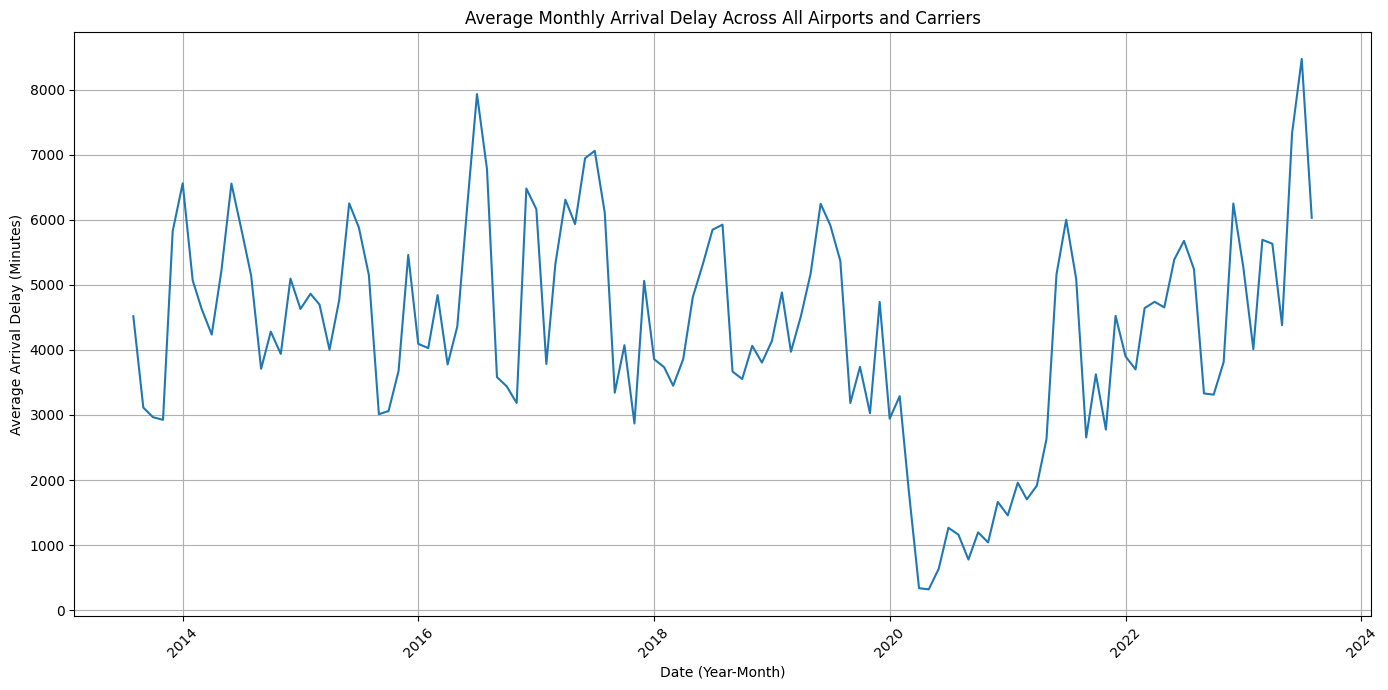


--- Arrival Delay Trend by Cause ---


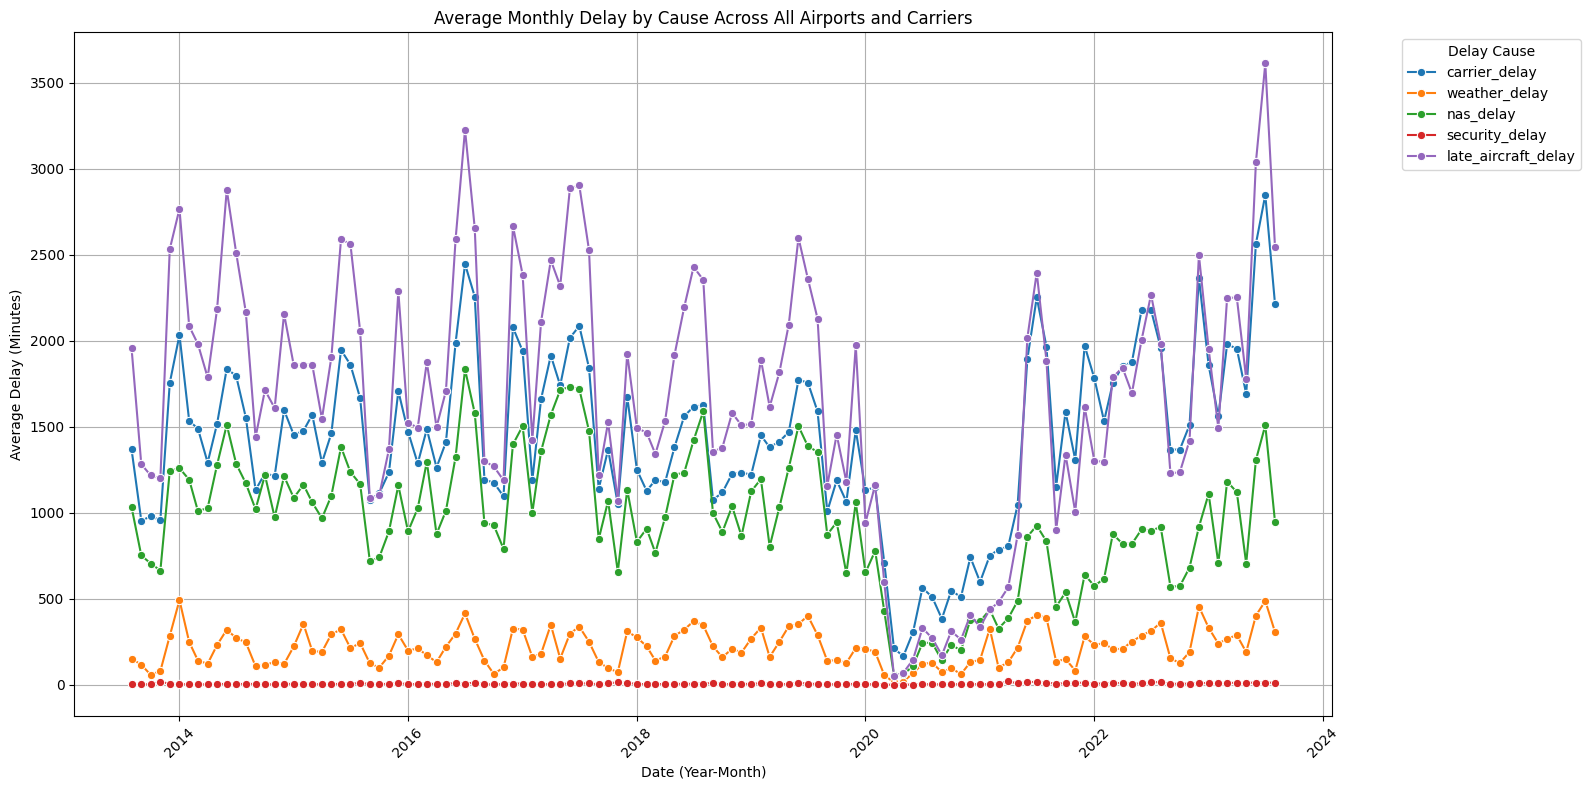


--- Yearly Summary of Average Delay Causes ---


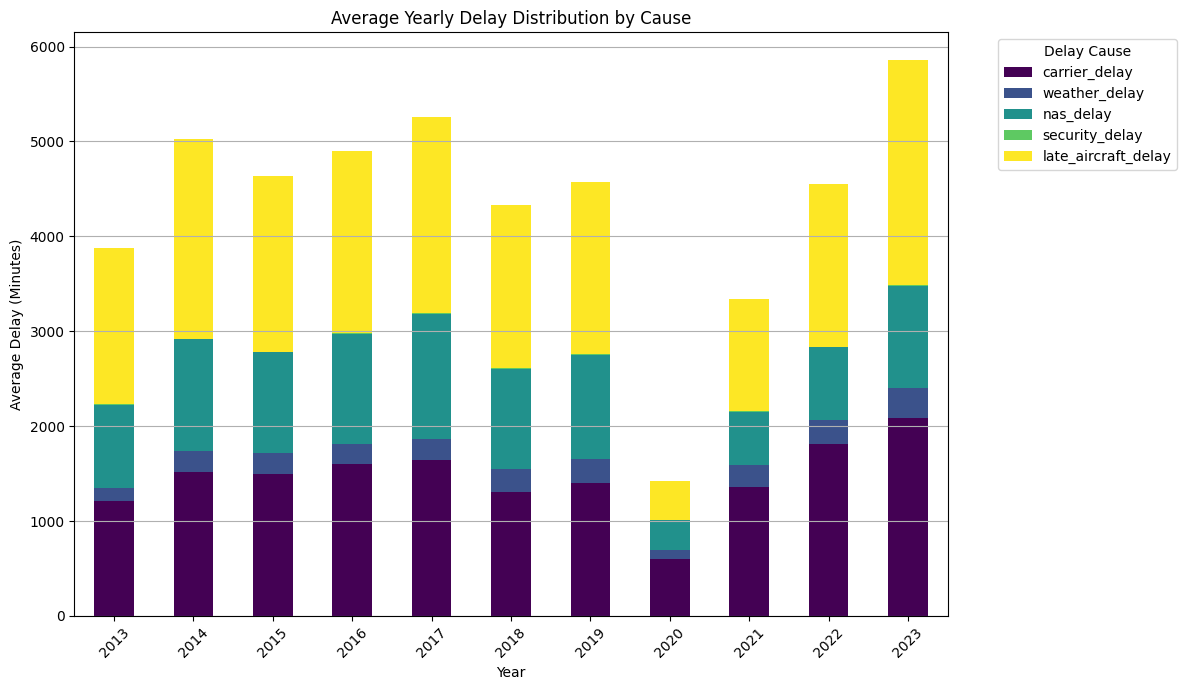


--- Airport-Specific Monthly Delay Trend (Example: ATL - Hartsfield-Jackson Atlanta) ---


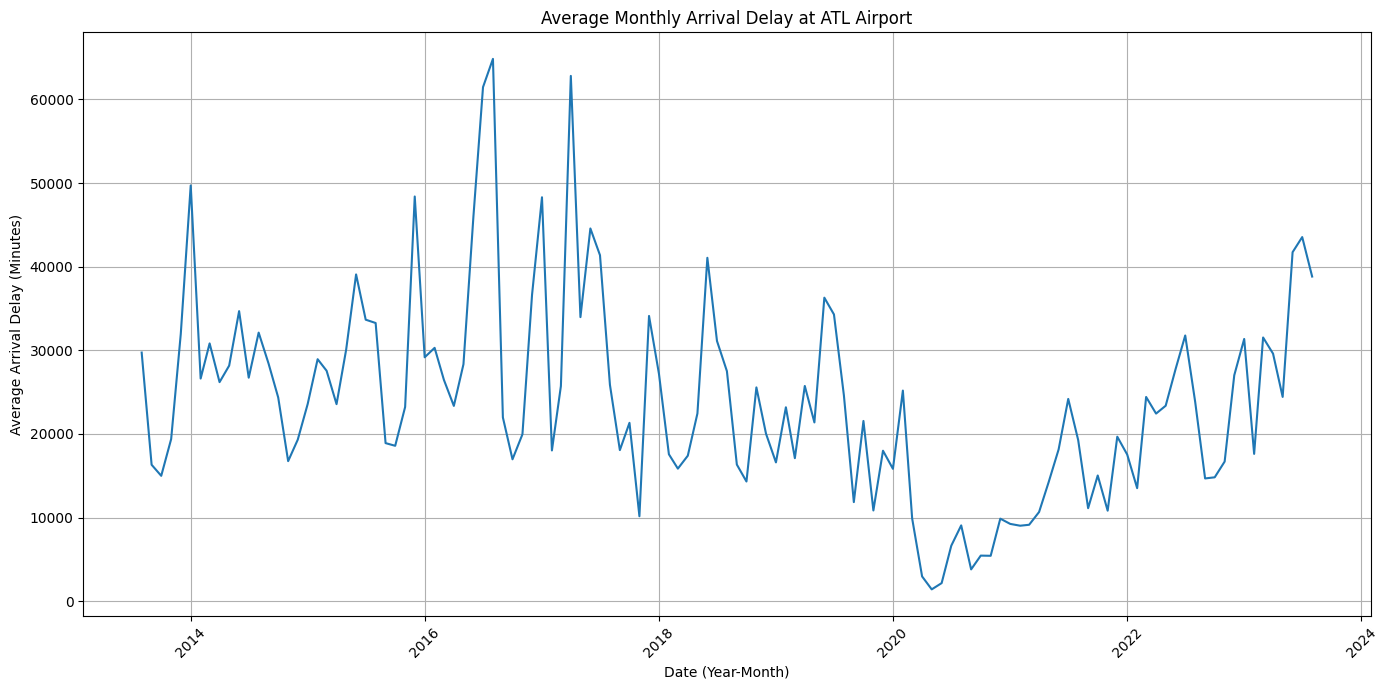

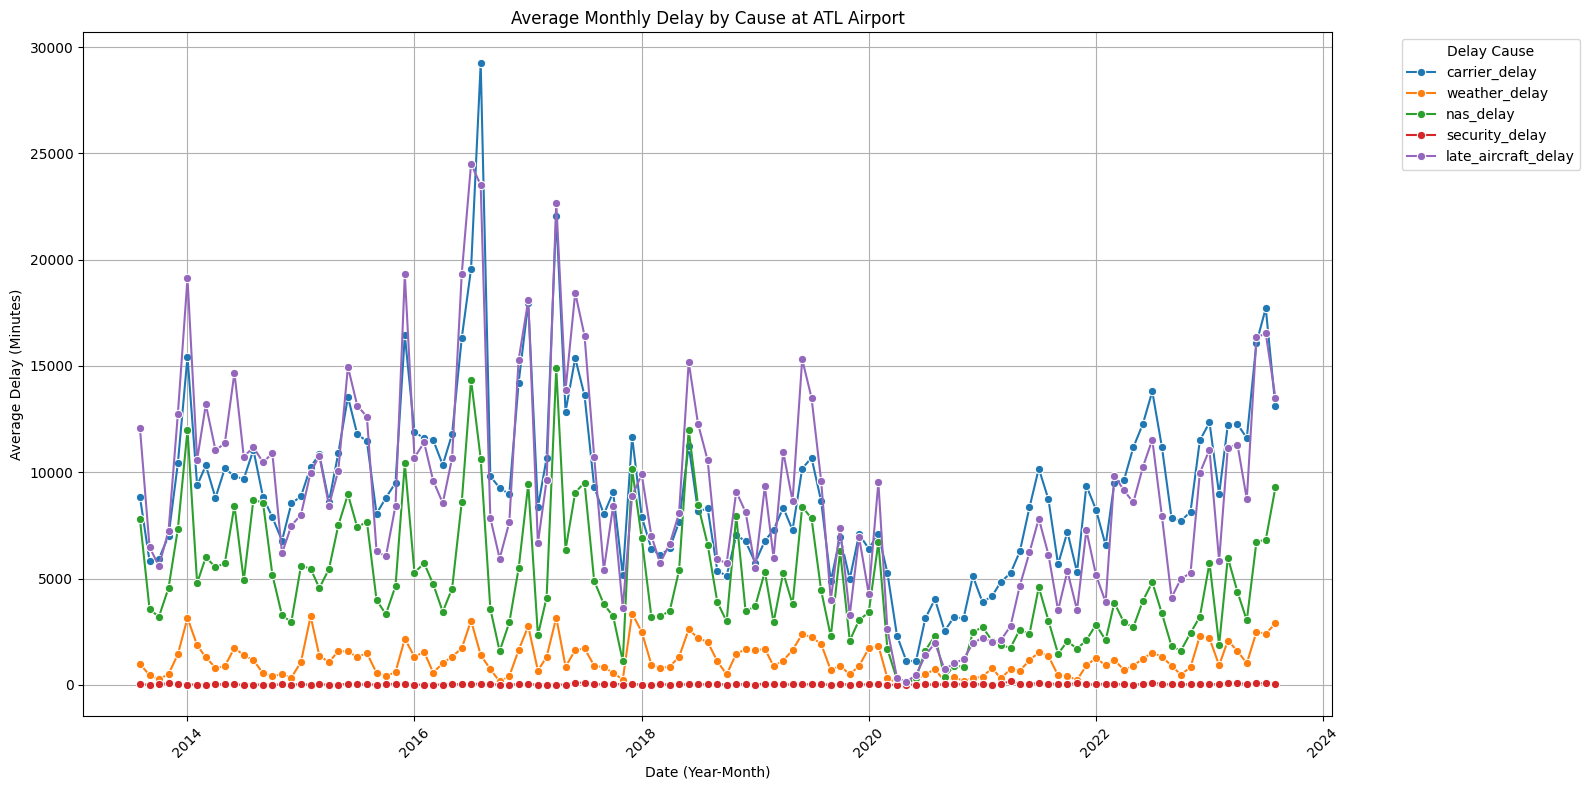


--- Carrier-Specific Monthly Delay Trend (Example: WN - Southwest Airlines) ---


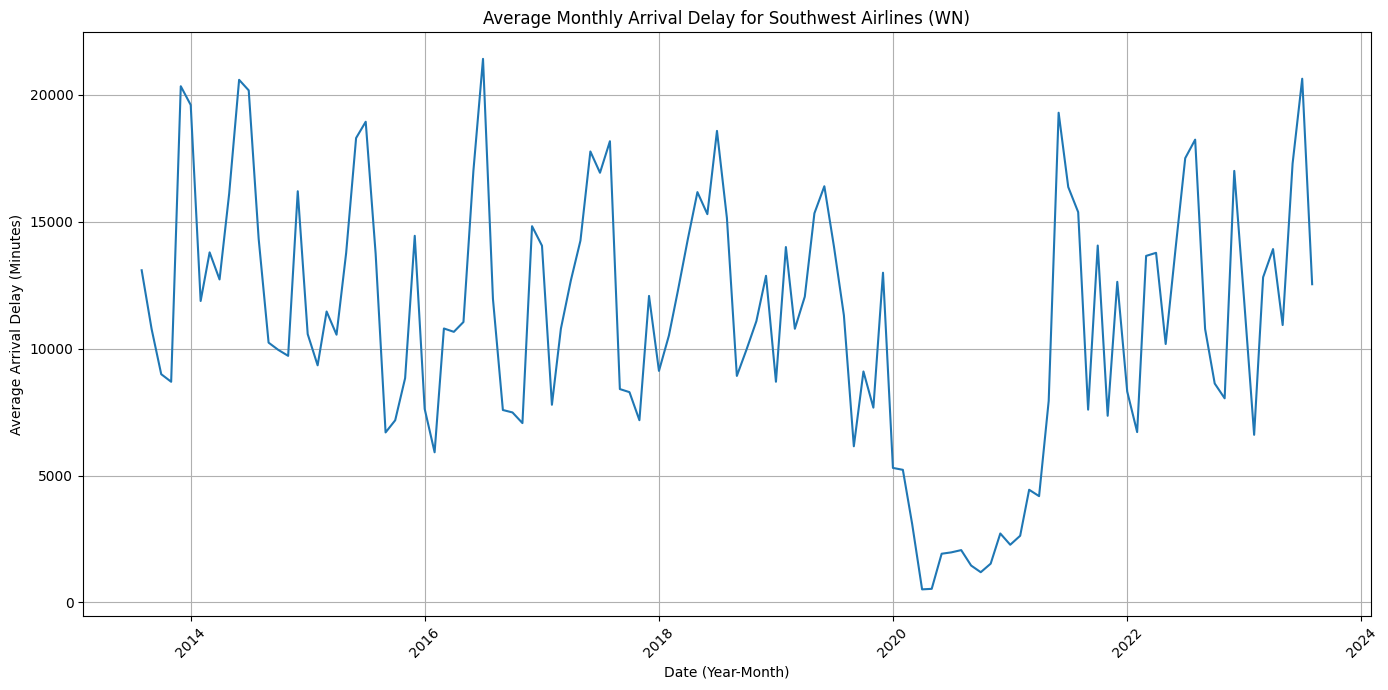

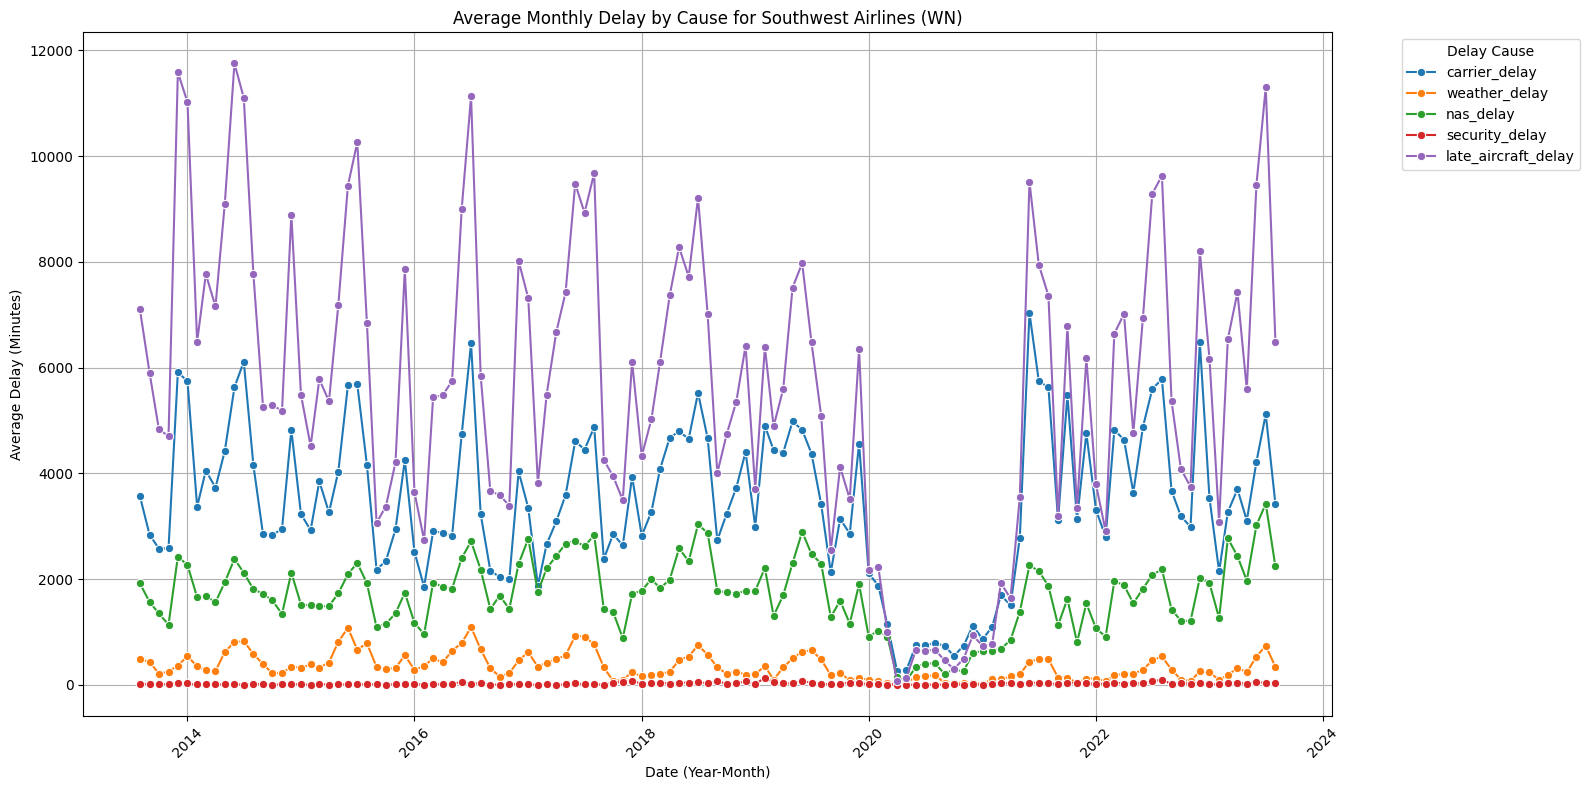

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Ensure numpy is imported

# --- 1. Prepare Data for Time-Series Analysis ---
# Create a 'date' column for easier plotting, treating each record as a point in time
# For aggregated monthly data, we can create a period string or datetime object
df_processed['year_month'] = df_processed['year'].astype(str) + '-' + df_processed['month'].astype(str).str.zfill(2)
df_processed['datetime_period'] = pd.to_datetime(df_processed['year_month'])

# Sort data by datetime for proper time series plotting
df_processed_sorted = df_processed.sort_values(by=['datetime_period'])

print("First few rows of df_processed with new time columns:")
print(df_processed_sorted[['year', 'month', 'datetime_period', 'arr_delay']].head())

# --- 2. Overall Arrival Delay Trend Over Time ---
print("\n--- Overall Arrival Delay Trend ---")
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_processed_sorted, x='datetime_period', y='arr_delay', estimator='mean', errorbar=None)
plt.title('Average Monthly Arrival Delay Across All Airports and Carriers')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 3. Arrival Delay Trend by Cause Over Time ---
print("\n--- Arrival Delay Trend by Cause ---")
# Select delay cause columns
delay_cause_cols = [
    'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay'
]

# Create a DataFrame for plotting, melting it for easier use with seaborn
df_causes_melted = df_processed_sorted.melt(
    id_vars=['datetime_period', 'year'],
    value_vars=delay_cause_cols,
    var_name='Delay_Cause_Type',
    value_name='Average_Delay_Minutes'
)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df_causes_melted,
    x='datetime_period',
    y='Average_Delay_Minutes',
    hue='Delay_Cause_Type',
    estimator='mean',
    errorbar=None,
    marker='o', # Add markers for clarity
    palette='tab10'
)
plt.title('Average Monthly Delay by Cause Across All Airports and Carriers')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Delay (Minutes)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 4. Yearly Summary of Average Delay Causes ---
print("\n--- Yearly Summary of Average Delay Causes ---")
yearly_avg_delays = df_processed_sorted.groupby('year')[delay_cause_cols].mean()

# Plot as a stacked bar chart or individual bars
yearly_avg_delays.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='viridis')
plt.title('Average Yearly Delay Distribution by Cause')
plt.xlabel('Year')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- 5. Airport-specific Monthly Delay Trends (Example for a Busiest Airport) ---
print("\n--- Airport-Specific Monthly Delay Trend (Example: ATL - Hartsfield-Jackson Atlanta) ---")
# Get the top N airports from your previous analysis or choose a known busy one
# For this example, let's pick 'ATL'
atl_data = df_processed_sorted[df_processed_sorted['airport'] == 'ATL']

if not atl_data.empty:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=atl_data, x='datetime_period', y='arr_delay', estimator='mean', errorbar=None)
    plt.title('Average Monthly Arrival Delay at ATL Airport')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Airport-specific causes
    atl_causes_melted = atl_data.melt(
        id_vars=['datetime_period', 'year'],
        value_vars=delay_cause_cols,
        var_name='Delay_Cause_Type',
        value_name='Average_Delay_Minutes'
    )
    plt.figure(figsize=(16, 8))
    sns.lineplot(
        data=atl_causes_melted,
        x='datetime_period',
        y='Average_Delay_Minutes',
        hue='Delay_Cause_Type',
        estimator='mean',
        errorbar=None,
        marker='o',
        palette='tab10'
    )
    plt.title('Average Monthly Delay by Cause at ATL Airport')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Average Delay (Minutes)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("ATL airport data not found in processed dataset. Skipping ATL-specific analysis.")

# --- 6. Carrier-specific Monthly Delay Trends (Example for a Major Carrier) ---
print("\n--- Carrier-Specific Monthly Delay Trend (Example: WN - Southwest Airlines) ---")
# For this example, let's pick 'WN'
wn_data = df_processed_sorted[df_processed_sorted['carrier'] == 'WN']

if not wn_data.empty:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=wn_data, x='datetime_period', y='arr_delay', estimator='mean', errorbar=None)
    plt.title('Average Monthly Arrival Delay for Southwest Airlines (WN)')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Carrier-specific causes
    wn_causes_melted = wn_data.melt(
        id_vars=['datetime_period', 'year'],
        value_vars=delay_cause_cols,
        var_name='Delay_Cause_Type',
        value_name='Average_Delay_Minutes'
    )
    plt.figure(figsize=(16, 8))
    sns.lineplot(
        data=wn_causes_melted,
        x='datetime_period',
        y='Average_Delay_Minutes',
        hue='Delay_Cause_Type',
        estimator='mean',
        errorbar=None,
        marker='o',
        palette='tab10'
    )
    plt.title('Average Monthly Delay by Cause for Southwest Airlines (WN)')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Average Delay (Minutes)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Southwest Airlines (WN) data not found in processed dataset. Skipping WN-specific analysis.")


--- Focusing on Subsets of Data ---

=== Subset: American Airlines (AA) ===
Shape of AA data: (11816, 22)
First 5 rows of AA data:
    year  month carrier airport  arr_flights  arr_del15  carrier_ct  \
92  2023      8      AA     ABQ        296.0       70.0       28.43   
93  2023      8      AA     ALB         93.0       23.0       10.29   
94  2023      8      AA     AMA         60.0       26.0       10.00   
95  2023      8      AA     ANC         93.0       37.0       13.00   
96  2023      8      AA     ATL        759.0      225.0       67.14   

    weather_ct  nas_ct  security_ct  ...  arr_diverted  arr_delay  \
92        0.00    6.64         0.00  ...           0.0     7128.0   
93        0.22    2.55         1.00  ...           0.0     1476.0   
94        0.00    1.21         0.00  ...           0.0     4719.0   
95        0.76   14.73         0.00  ...           0.0     1528.0   
96       14.76   38.73         0.21  ...           5.0    20112.0   

    carrier_delay  weather

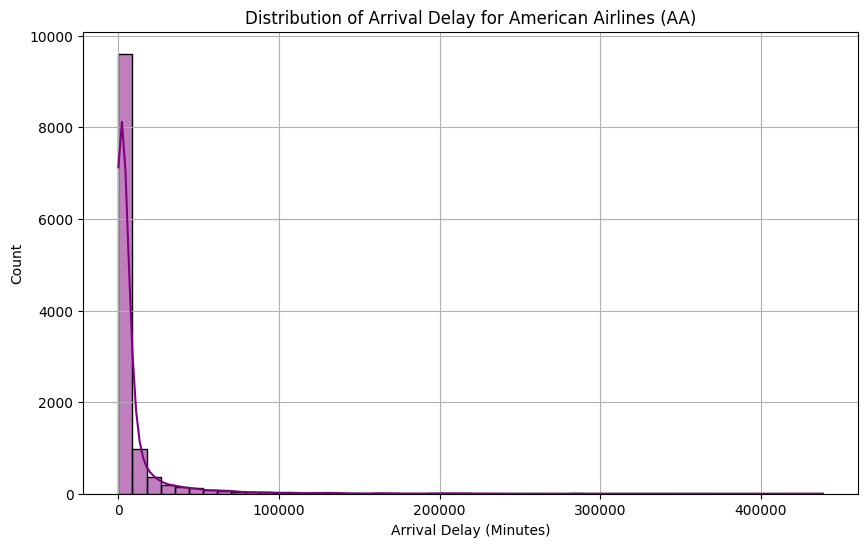


Total delay minutes by cause for AA:
late_aircraft_delay    40980232.0
carrier_delay          36455506.0
nas_delay              20797721.0
weather_delay           5315301.0
security_delay           212423.0
dtype: float64

=== Subset: Los Angeles International Airport (LAX) ===
Shape of LAX data: (1377, 22)
First 5 rows of LAX data:
     year  month carrier airport  arr_flights  arr_del15  carrier_ct  \
153  2023      8      AA     LAX       2611.0      661.0      228.63   
264  2023      8      AS     LAX        860.0      217.0       61.02   
338  2023      8      B6     LAX       1105.0      362.0      146.08   
446  2023      8      DL     LAX       3348.0      610.0      252.91   
650  2023      8      G4     LAX        138.0       63.0       14.07   

     weather_ct  nas_ct  security_ct  ...  arr_diverted  arr_delay  \
153       24.32  131.79         0.66  ...           8.0    64858.0   
264        4.46   83.52         3.33  ...           0.0    13128.0   
338        3.67  131.

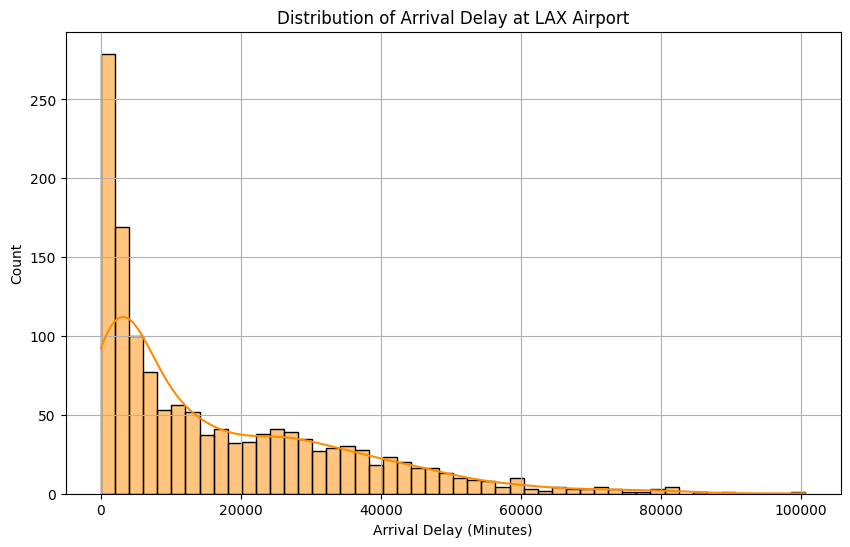


Total delay minutes by cause for LAX:
late_aircraft_delay    8801092.0
carrier_delay          8192667.0
nas_delay              5364691.0
weather_delay           994751.0
security_delay           57143.0
dtype: float64

=== Subset: Data for Year 2019 ===
Shape of 2019 data: (20946, 22)
First 5 rows of 2019 data:
       year  month carrier airport  arr_flights  arr_del15  carrier_ct  \
71531  2019     12      9E     ABE         53.0        6.0        3.05   
71532  2019     12      9E     AEX        115.0        4.0        0.03   
71533  2019     12      9E     AGS        191.0       13.0        7.49   
71534  2019     12      9E     ALB          6.0        1.0        0.00   
71535  2019     12      9E     ATL       3802.0      468.0      115.80   

       weather_ct  nas_ct  security_ct  ...  arr_diverted  arr_delay  \
71531        0.22    0.21         0.00  ...           0.0      265.0   
71532        0.00    1.35         0.00  ...           2.0      157.0   
71533        2.31    1.48

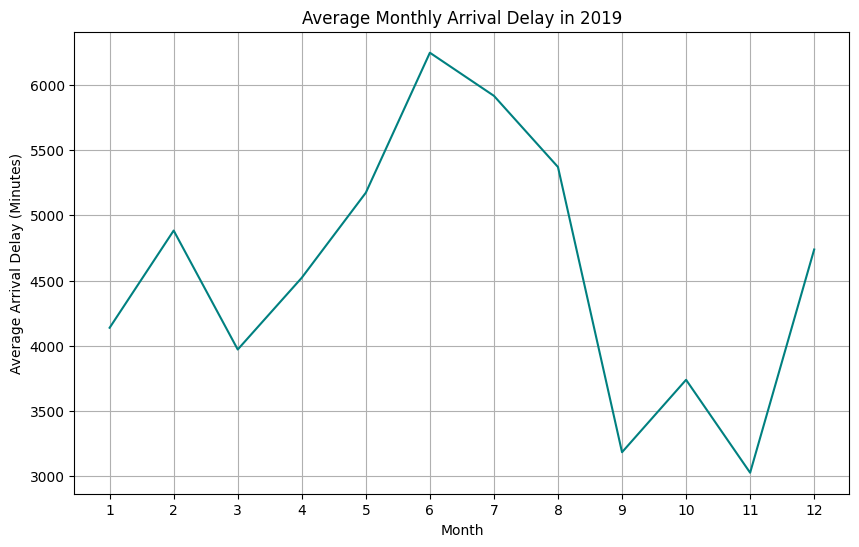


=== Subset: WN flights at PHX in 2020 ===
Shape of WN at PHX in 2020 data: (12, 22)
First 5 rows of WN at PHX in 2020 data:
       year  month carrier airport  arr_flights  arr_del15  carrier_ct  \
54028  2020     12      WN     PHX       3384.0      281.0      104.49   
55506  2020     11      WN     PHX       3712.0      168.0       66.12   
57032  2020     10      WN     PHX       3324.0      176.0       52.43   
58521  2020      9      WN     PHX       3367.0      114.0       52.41   
60071  2020      8      WN     PHX       4110.0      152.0       76.06   

       weather_ct  nas_ct  security_ct  ...  arr_diverted  arr_delay  \
54028        3.60   77.06         2.00  ...           1.0     9624.0   
55506        2.87   50.87         0.65  ...           3.0     7625.0   
57032        1.82   76.68         2.00  ...           0.0     6201.0   
58521        2.84   19.09         0.00  ...           5.0     5797.0   
60071       10.86   21.00         0.00  ...          21.0     7228.0  

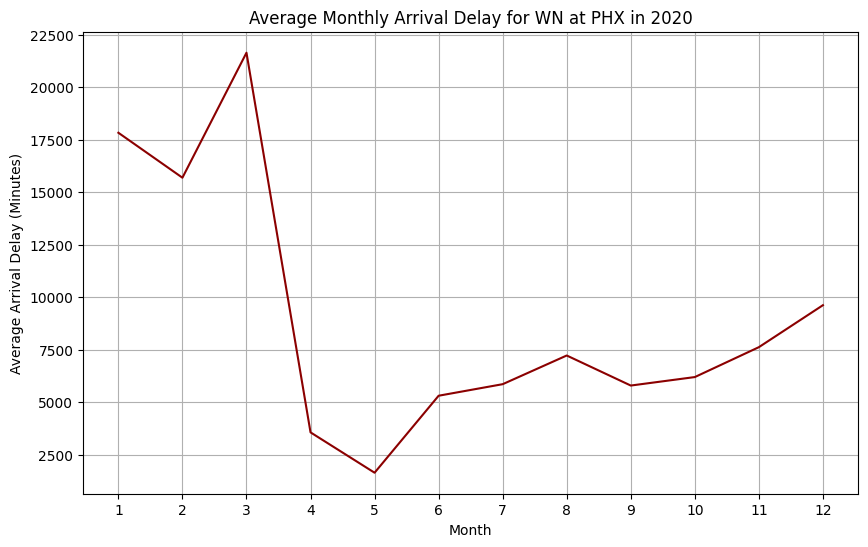


Total delay minutes by cause for WN at PHX in 2020:
carrier_delay          44391.0
late_aircraft_delay    35910.0
nas_delay              24139.0
weather_delay           3217.0
security_delay           386.0
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure df_processed is available from previous steps
# If you ran the previous time-series analysis, df_processed_sorted is also available
# For general subsetting, df_processed is sufficient.
# If you need 'datetime_period' for time-based subsetting, ensure it's created:
if 'datetime_period' not in df_processed.columns:
    df_processed['year_month'] = df_processed['year'].astype(str) + '-' + df_processed['month'].astype(str).str.zfill(2)
    df_processed['datetime_period'] = pd.to_datetime(df_processed['year_month'])


print("\n--- Focusing on Subsets of Data ---")

# --- Subset 1: By a Specific Carrier ---
# Let's focus on 'AA' (American Airlines) as an example
print("\n=== Subset: American Airlines (AA) ===")
aa_data = df_processed[df_processed['carrier'] == 'AA'].copy() # .copy() to avoid SettingWithCopyWarning

print(f"Shape of AA data: {aa_data.shape}")
print("First 5 rows of AA data:")
print(aa_data.head())

print("\nDescriptive statistics for AA delays:")
print(aa_data['arr_delay'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(aa_data['arr_delay'], bins=50, kde=True, color='purple')
plt.title('Distribution of Arrival Delay for American Airlines (AA)')
plt.xlabel('Arrival Delay (Minutes)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# You can also analyze delay causes for this subset
aa_delay_causes = aa_data[['carrier_delay', 'weather_delay', 'nas_delay',
                            'security_delay', 'late_aircraft_delay']].sum()
print("\nTotal delay minutes by cause for AA:")
print(aa_delay_causes.sort_values(ascending=False))

# --- Subset 2: By a Specific Airport ---
# Let's focus on 'LAX' (Los Angeles International Airport) as an example
print("\n=== Subset: Los Angeles International Airport (LAX) ===")
lax_data = df_processed[df_processed['airport'] == 'LAX'].copy()

print(f"Shape of LAX data: {lax_data.shape}")
print("First 5 rows of LAX data:")
print(lax_data.head())

print("\nDescriptive statistics for LAX delays:")
print(lax_data['arr_delay'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(lax_data['arr_delay'], bins=50, kde=True, color='darkorange')
plt.title('Distribution of Arrival Delay at LAX Airport')
plt.xlabel('Arrival Delay (Minutes)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Analyze delay causes for LAX
lax_delay_causes = lax_data[['carrier_delay', 'weather_delay', 'nas_delay',
                            'security_delay', 'late_aircraft_delay']].sum()
print("\nTotal delay minutes by cause for LAX:")
print(lax_delay_causes.sort_values(ascending=False))

# --- Subset 3: By a Specific Time Period (e.g., All of 2019) ---
print("\n=== Subset: Data for Year 2019 ===")
year_2019_data = df_processed[df_processed['year'] == 2019].copy()

print(f"Shape of 2019 data: {year_2019_data.shape}")
print("First 5 rows of 2019 data:")
print(year_2019_data.head())

print("\nDescriptive statistics for 2019 delays:")
print(year_2019_data['arr_delay'].describe())

plt.figure(figsize=(10, 6))
sns.lineplot(data=year_2019_data, x='month', y='arr_delay', estimator='mean', errorbar=None, color='teal')
plt.title('Average Monthly Arrival Delay in 2019')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# --- Subset 4: Combined Criteria (e.g., Southwest Airlines (WN) at Phoenix Sky Harbor (PHX) in 2020) ---
print("\n=== Subset: WN flights at PHX in 2020 ===")
combined_subset = df_processed[
    (df_processed['carrier'] == 'WN') &
    (df_processed['airport'] == 'PHX') &
    (df_processed['year'] == 2020)
].copy()

print(f"Shape of WN at PHX in 2020 data: {combined_subset.shape}")
print("First 5 rows of WN at PHX in 2020 data:")
print(combined_subset.head())

if not combined_subset.empty:
    print("\nDescriptive statistics for WN at PHX in 2020 delays:")
    print(combined_subset['arr_delay'].describe())

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_subset, x='month', y='arr_delay', estimator='mean', errorbar=None, color='darkred')
    plt.title('Average Monthly Arrival Delay for WN at PHX in 2020')
    plt.xlabel('Month')
    plt.ylabel('Average Arrival Delay (Minutes)')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.show()

    # Analyze delay causes for this specific combined subset
    combined_delay_causes = combined_subset[['carrier_delay', 'weather_delay', 'nas_delay',
                                            'security_delay', 'late_aircraft_delay']].sum()
    print("\nTotal delay minutes by cause for WN at PHX in 2020:")
    print(combined_delay_causes.sort_values(ascending=False))
else:
    print("No data found for WN flights at PHX in 2020 within the dataset.")


--- Building and Training Random Forest Regressor ---

Random Forest Regressor training finished.

--- Making Predictions on Test Data with Random Forest ---
Random Forest predictions completed.

--- Metrics for Random Forest ---
Mean Absolute Error (MAE): 251.8708
Mean Squared Error (MSE): 1092864.2948
Root Mean Squared Error (RMSE): 1045.4015
R² Score: 0.9933
Mean Absolute Percentage Error (MAPE, excluding 0 true values): 21.3752%

--- Consolidated Model Performance Metrics on Test Set (with Random Forest) ---
                   MAE           MSE       RMSE  R2 Score     MAPE
XGBoost       283.5089  3.191723e+06  1786.5393    0.9804  25.0973
LSTM          768.6700  7.672127e+06  2769.8605    0.9528  39.7489
RandomForest  251.8708  1.092864e+06  1045.4015    0.9933  21.3752


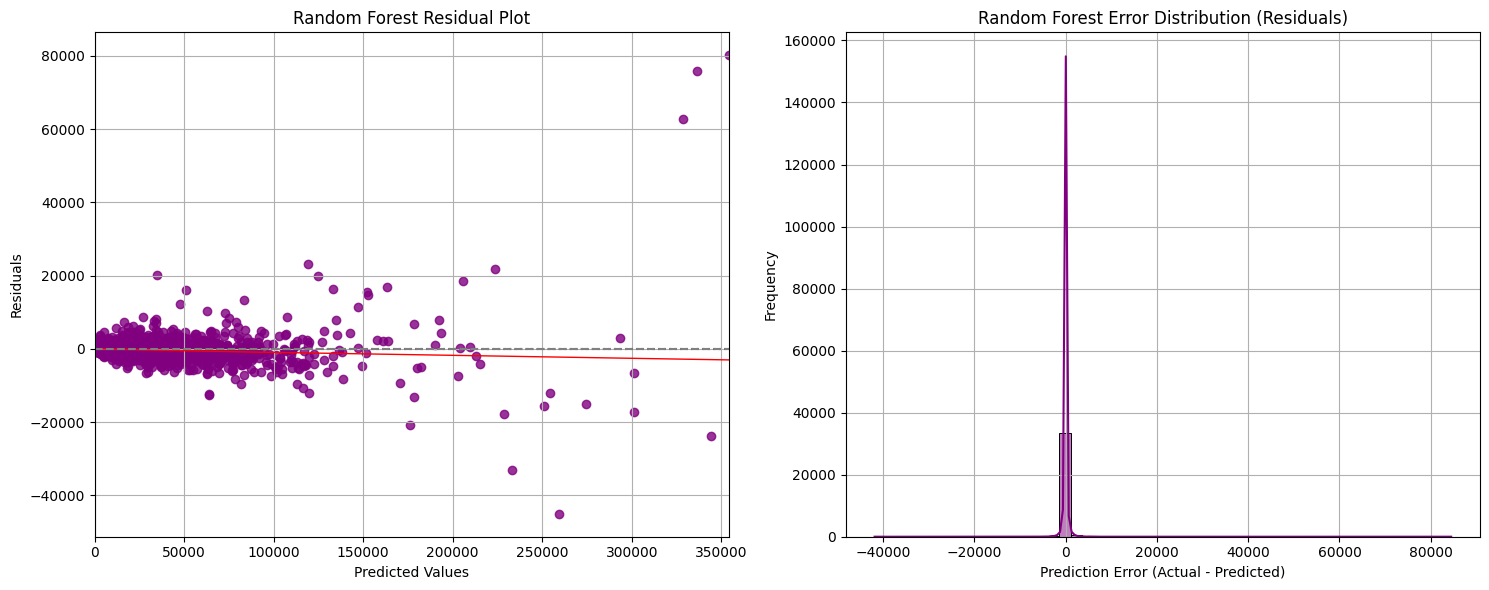

<ipython-input-20-9c09759377f9>:57: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red') # Ideal line


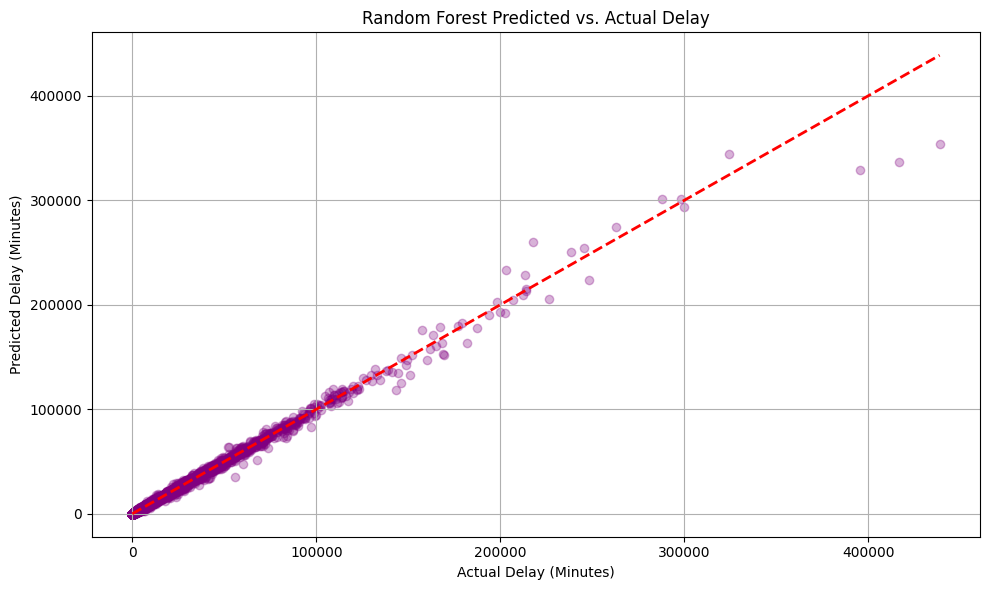


--- Random Forest Feature Importance ---
arr_del15              0.766100
late_aircraft_delay    0.174226
nas_delay              0.018980
carrier_delay          0.016873
carrier_delay          0.014785
nas_ct                 0.003288
weather_delay          0.001620
late_aircraft_ct       0.001199
weather_ct             0.000626
carrier_WN             0.000582
dtype: float64


<ipython-input-20-9c09759377f9>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_feature_importance.head(10).values, y=rf_feature_importance.head(10).index, palette='plasma')


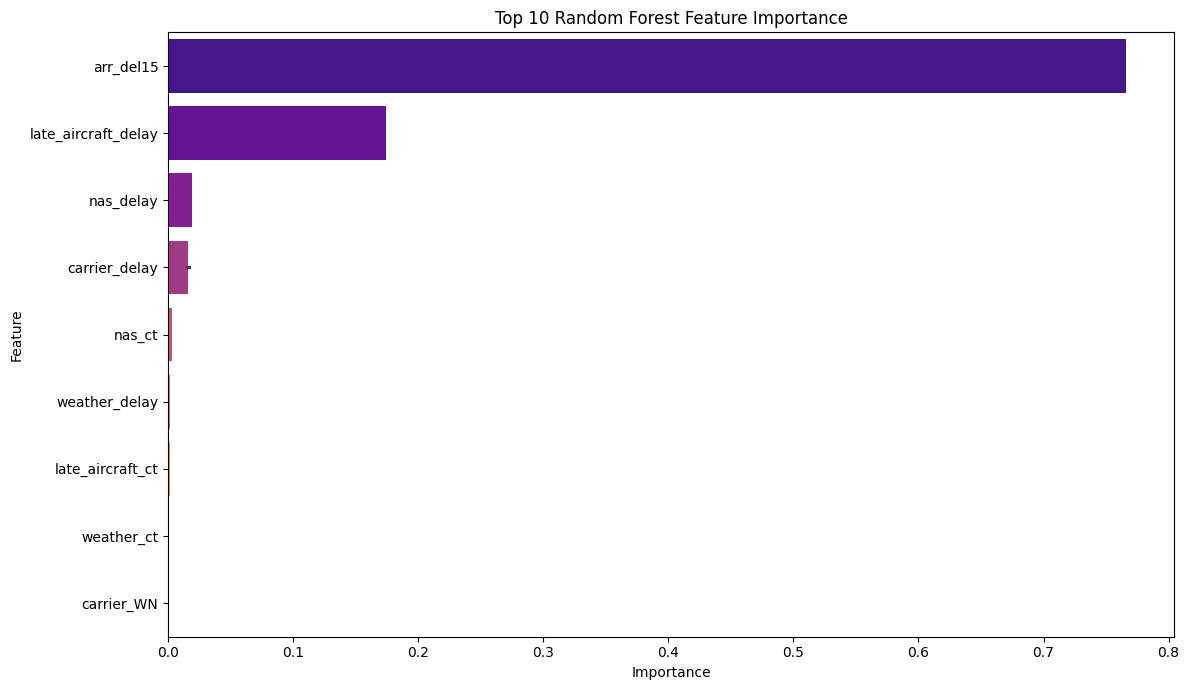

In [ ]:
from sklearn.ensemble import RandomForestRegressor

print("\n--- Building and Training Random Forest Regressor ---")

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=10,          # Maximum depth of the tree (adjust based on performance)
    min_samples_split=5,   # Minimum number of samples required to split an internal node
    random_state=42,
    n_jobs=-1              # Use all available cores
)

# Train the model
rf_model.fit(X_train_final, y_train)

print("\nRandom Forest Regressor training finished.")

# --- Make Predictions with Random Forest ---
print("\n--- Making Predictions on Test Data with Random Forest ---")
y_pred_rf = rf_model.predict(X_test_final)
print("Random Forest predictions completed.")

# --- Evaluate Random Forest Performance ---
metrics_summary['RandomForest'] = calculate_regression_metrics(y_test, y_pred_rf, 'Random Forest')

# Update and display consolidated metrics
metrics_df = pd.DataFrame.from_dict(metrics_summary, orient='index')
print("\n--- Consolidated Model Performance Metrics on Test Set (with Random Forest) ---")
print(metrics_df.round(4))

# --- Visualizations for Random Forest Performance ---

# Residual Plot for Random Forest
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred_rf, y=y_test, lowess=True, color="purple", line_kws={'color': 'red', 'lw': 1})
plt.title('Random Forest Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True)

# Error Distribution Histogram for Random Forest
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred_rf, bins=50, kde=True, color='purple')
plt.title('Random Forest Error Distribution (Residuals)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs Actual Scatter Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red') # Ideal line
plt.title('Random Forest Predicted vs. Actual Delay')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Random Forest Feature Importance ---
print("\n--- Random Forest Feature Importance ---")
rf_feature_importance = pd.Series(rf_model.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
print(rf_feature_importance.head(10)) # Print top 10

plt.figure(figsize=(12, 7))
sns.barplot(x=rf_feature_importance.head(10).values, y=rf_feature_importance.head(10).index, palette='plasma')
plt.title('Top 10 Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
print("1. Dataset Shape and Memory Usage:")
print(f"Number of rows: {df_processed.shape[0]}")
print(f"Number of columns: {df_processed.shape[1]}")
print("\nMemory usage:")
df_processed.info(verbose=False, memory_usage="deep")
print("\n" + "="*50 + "\n")

1. Dataset Shape and Memory Usage:
Number of rows: 171666
Number of columns: 22

Memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171666 entries, 0 to 171665
Columns: 22 entries, year to datetime_period
dtypes: datetime64[ns](1), float64(16), int64(2), object(3)
memory usage: 54.8 MB




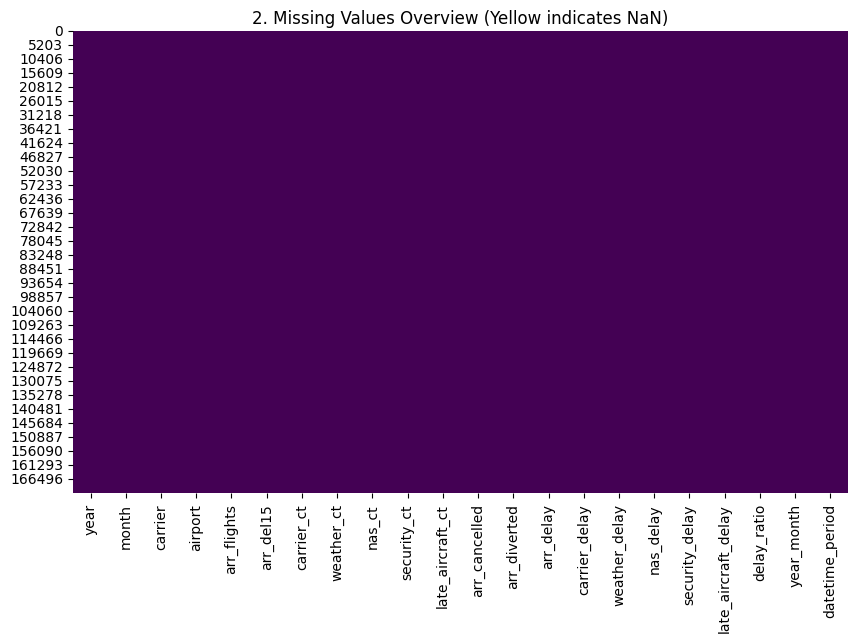

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_processed.isnull(), cbar=False, cmap='viridis')
plt.title('2. Missing Values Overview (Yellow indicates NaN)')
plt.show()
print("\n" + "="*50 + "\n")

In [ ]:
print("3. Unique Carriers and Airports:")
print(f"Number of unique carriers: {df_processed['carrier'].nunique()}")
print(f"Unique carriers: {df_processed['carrier'].unique()}")
print(f"\nNumber of unique airports: {df_processed['airport'].nunique()}")
# print(f"Unique airports: {df_processed['airport'].unique()}") # Uncomment for full list
print("\n" + "="*50 + "\n")

3. Unique Carriers and Airports:
Number of unique carriers: 21
Unique carriers: ['9E' 'AA' 'AS' 'B6' 'DL' 'F9' 'G4' 'HA' 'MQ' 'NK' 'OH' 'OO' 'UA' 'WN'
 'YX' 'QX' 'YV' 'EV' 'VX' 'US' 'FL']

Number of unique airports: 395




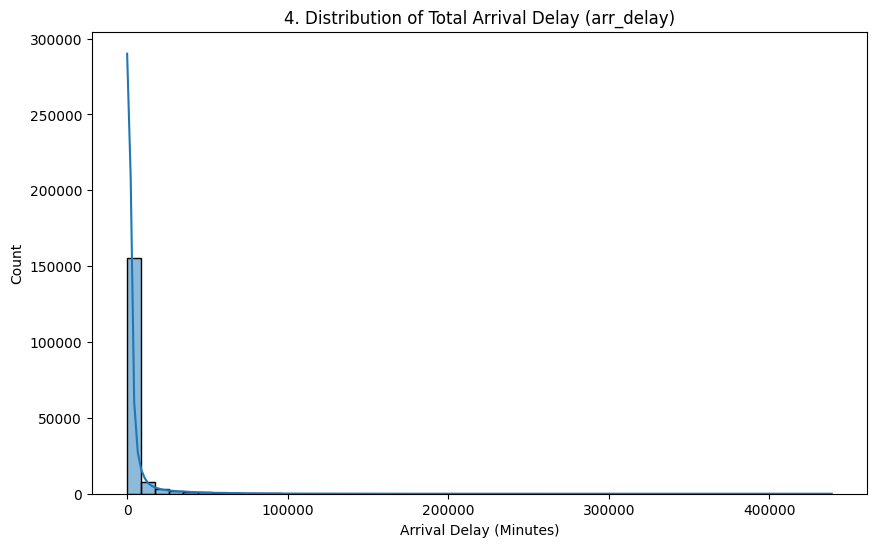

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['arr_delay'], bins=50, kde=True)
plt.title('4. Distribution of Total Arrival Delay (arr_delay)')
plt.xlabel('Arrival Delay (Minutes)')
plt.ylabel('Count')
plt.show()
print("\n" + "="*50 + "\n")

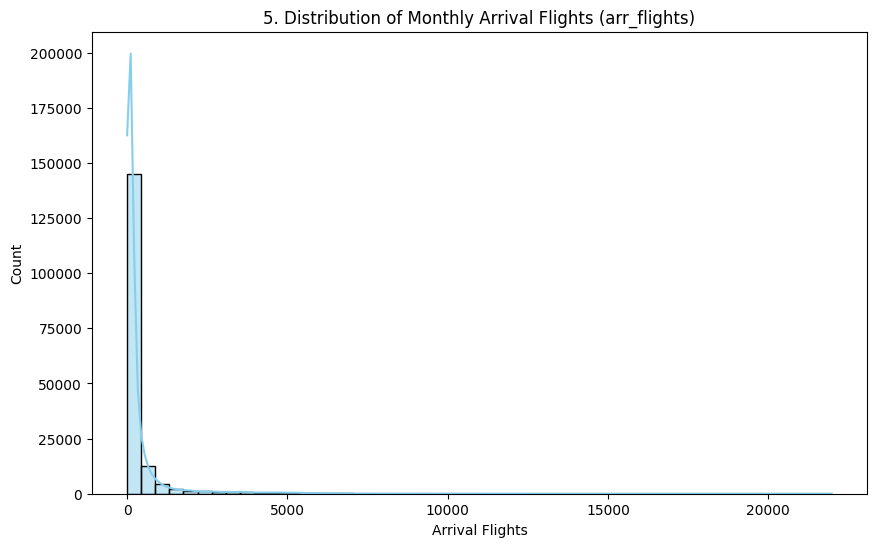

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['arr_flights'], bins=50, kde=True, color='skyblue')
plt.title('5. Distribution of Monthly Arrival Flights (arr_flights)')
plt.xlabel('Arrival Flights')
plt.ylabel('Count')
plt.show()
print("\n" + "="*50 + "\n")

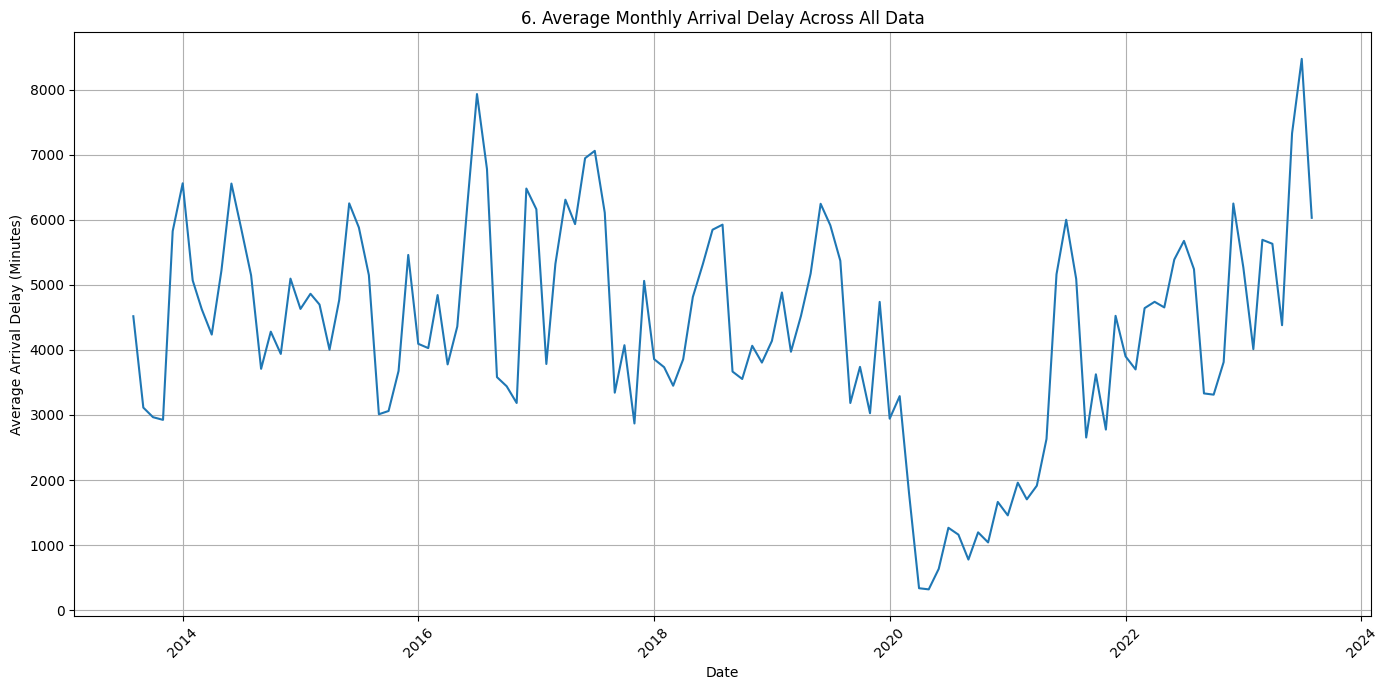

In [ ]:
# Ensure datetime_period exists:
if 'datetime_period' not in df_processed.columns:
    df_processed['year_month'] = df_processed['year'].astype(str) + '-' + df_processed['month'].astype(str).str.zfill(2)
    df_processed['datetime_period'] = pd.to_datetime(df_processed['year_month'])
df_processed_sorted = df_processed.sort_values(by=['datetime_period'])

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_processed_sorted, x='datetime_period', y='arr_delay', estimator='mean', errorbar=None)
plt.title('6. Average Monthly Arrival Delay Across All Data')
plt.xlabel('Date')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

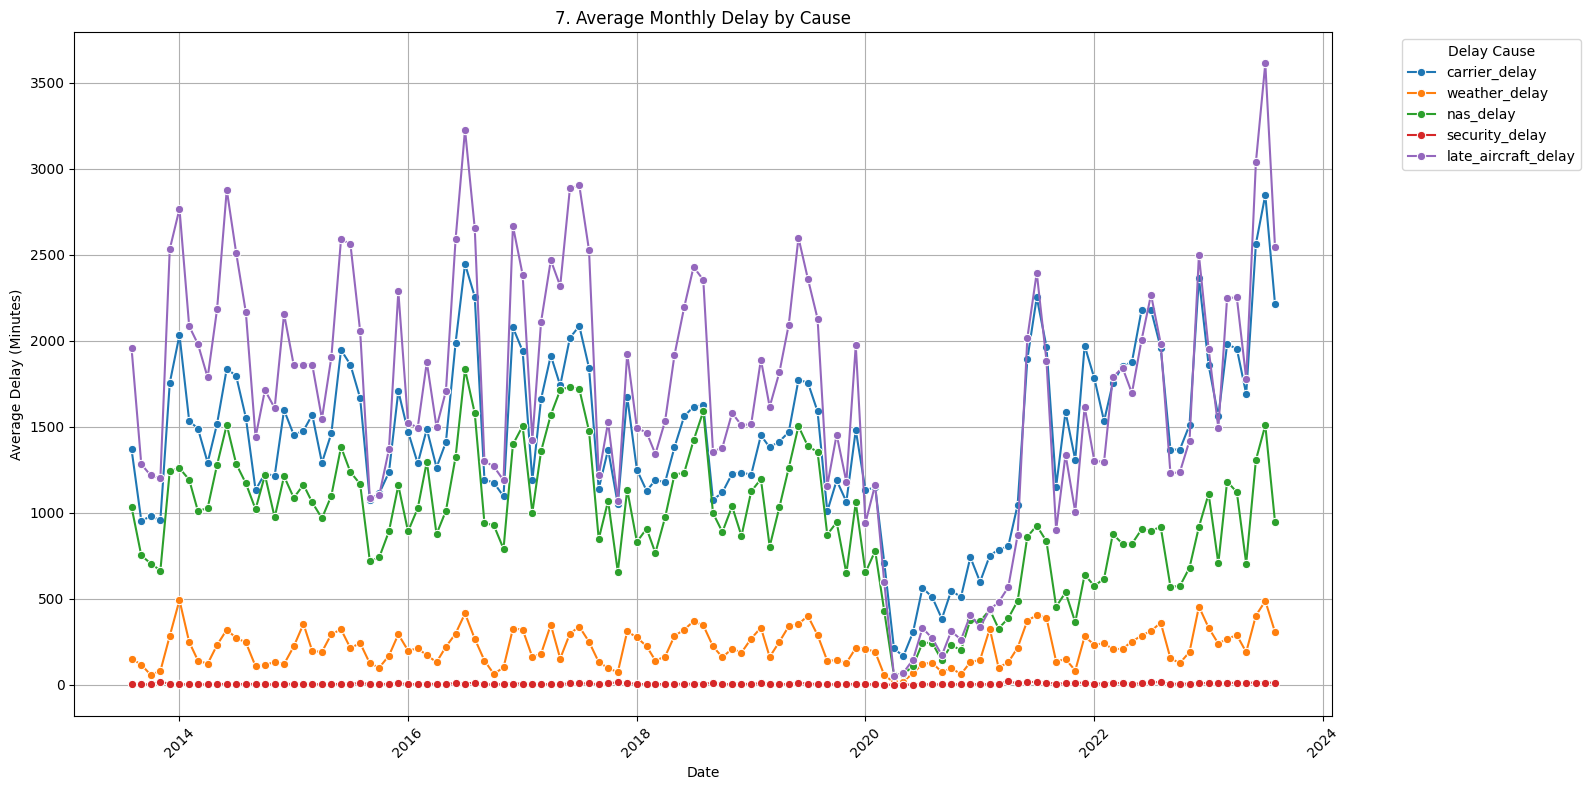

In [ ]:
delay_cause_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
df_causes_melted = df_processed_sorted.melt(
    id_vars=['datetime_period'], value_vars=delay_cause_cols,
    var_name='Delay_Cause_Type', value_name='Average_Delay_Minutes'
)
plt.figure(figsize=(16, 8))
sns.lineplot(data=df_causes_melted, x='datetime_period', y='Average_Delay_Minutes',
             hue='Delay_Cause_Type', estimator='mean', errorbar=None, marker='o', palette='tab10')
plt.title('7. Average Monthly Delay by Cause')
plt.xlabel('Date')
plt.ylabel('Average Delay (Minutes)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

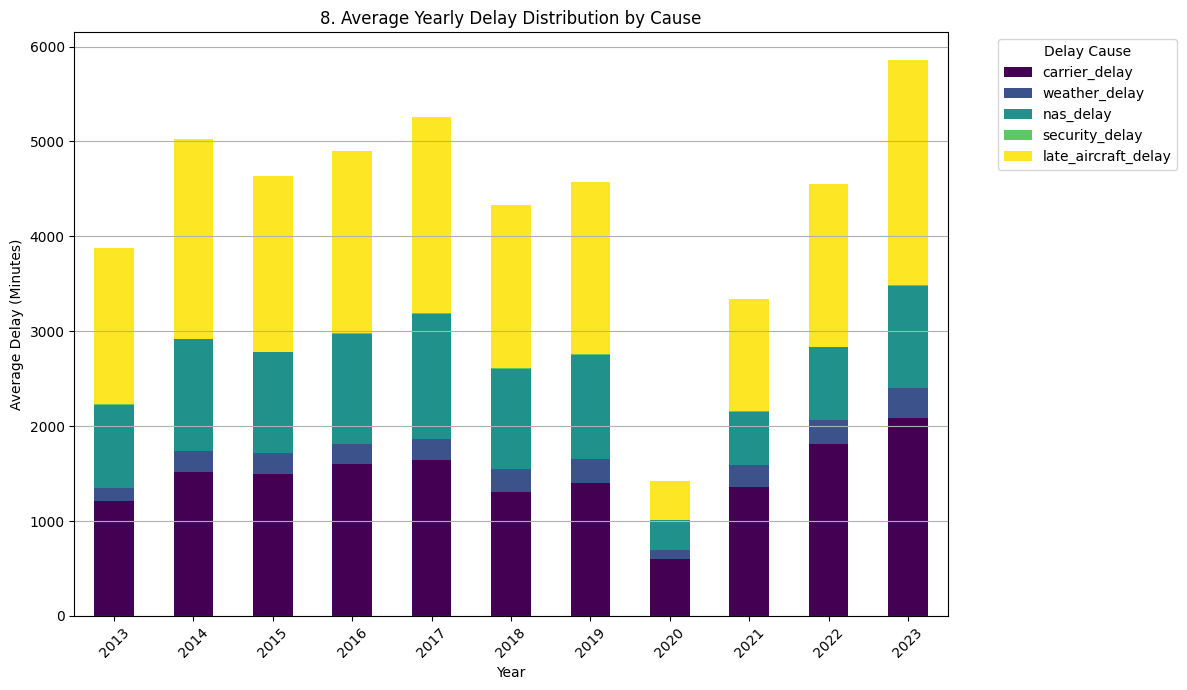

In [ ]:
yearly_avg_delays = df_processed_sorted.groupby('year')[delay_cause_cols].mean()
yearly_avg_delays.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='viridis')
plt.title('8. Average Yearly Delay Distribution by Cause')
plt.xlabel('Year')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

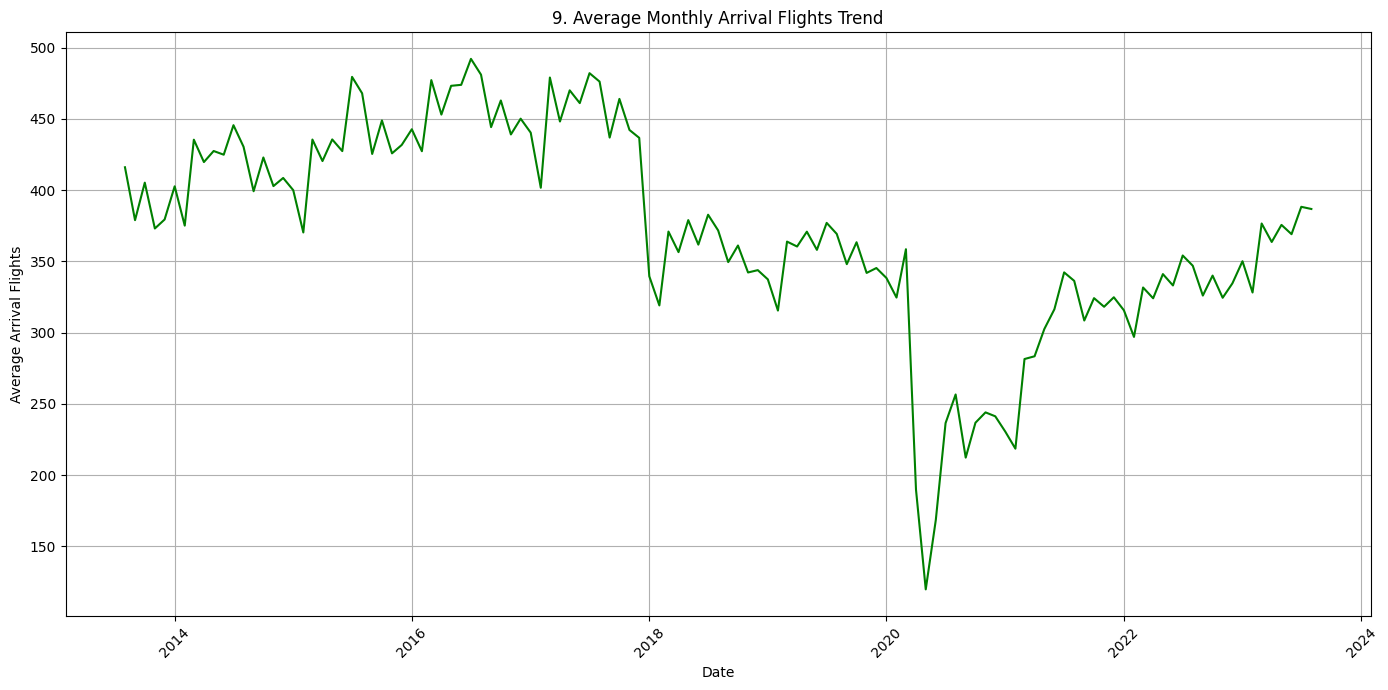

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_processed_sorted, x='datetime_period', y='arr_flights', estimator='mean', errorbar=None, color='green')
plt.title('9. Average Monthly Arrival Flights Trend')
plt.xlabel('Date')
plt.ylabel('Average Arrival Flights')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-30-0a5715b73809>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='arr_delay', data=monthly_overall_avg, palette='Reds_r')


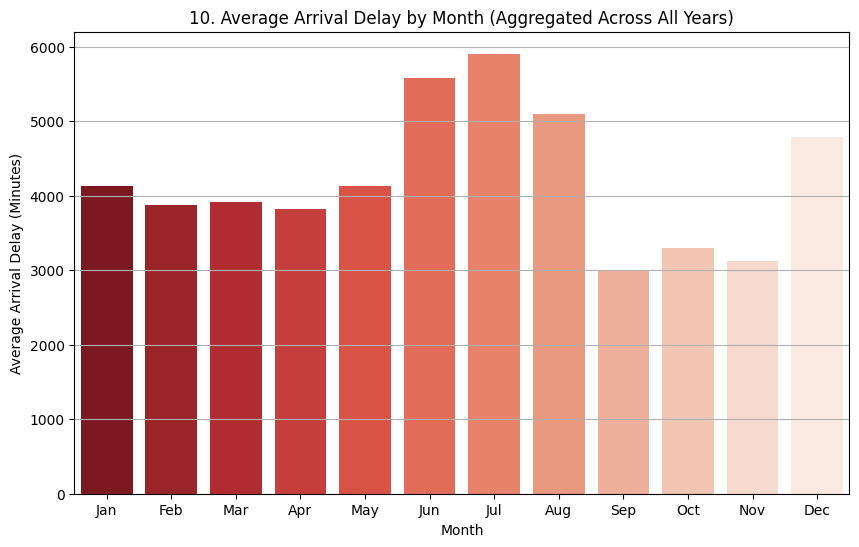

In [ ]:
monthly_overall_avg = df_processed.groupby('month')['arr_delay'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='arr_delay', data=monthly_overall_avg, palette='Reds_r')
plt.title('10. Average Arrival Delay by Month (Aggregated Across All Years)')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.xticks(ticks=range(0,12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(axis='y')
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-31-fe31d3a8a5e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airport_avg_delay.values, y=airport_avg_delay.index, palette='crest')


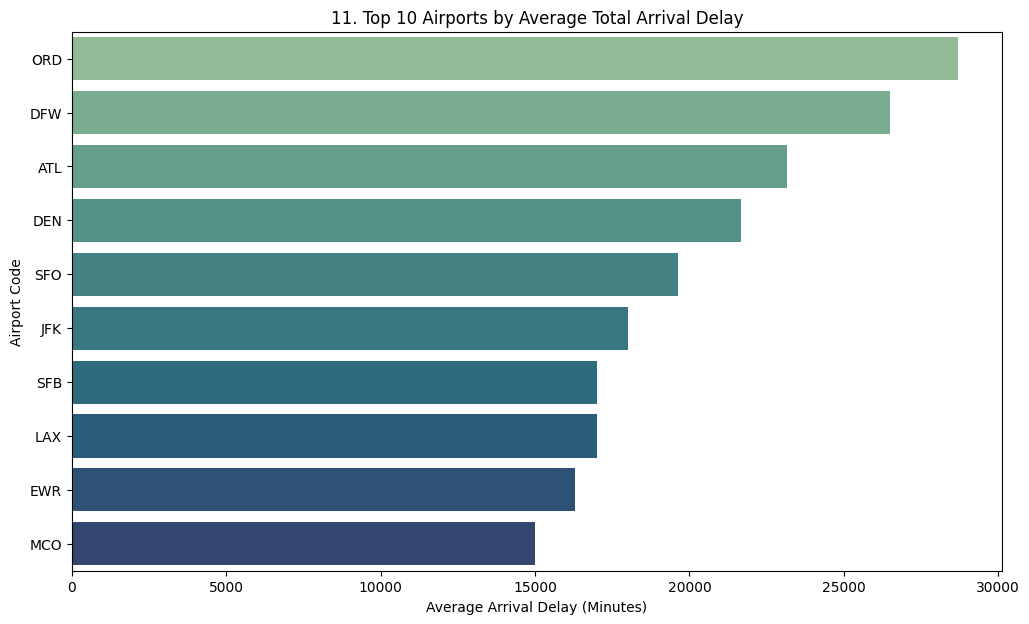

In [ ]:
airport_avg_delay = df_processed.groupby('airport')['arr_delay'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=airport_avg_delay.values, y=airport_avg_delay.index, palette='crest')
plt.title('11. Top 10 Airports by Average Total Arrival Delay')
plt.xlabel('Average Arrival Delay (Minutes)')
plt.ylabel('Airport Code')
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-32-529a40bc013c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airport_total_flights.values, y=airport_total_flights.index, palette='mako')


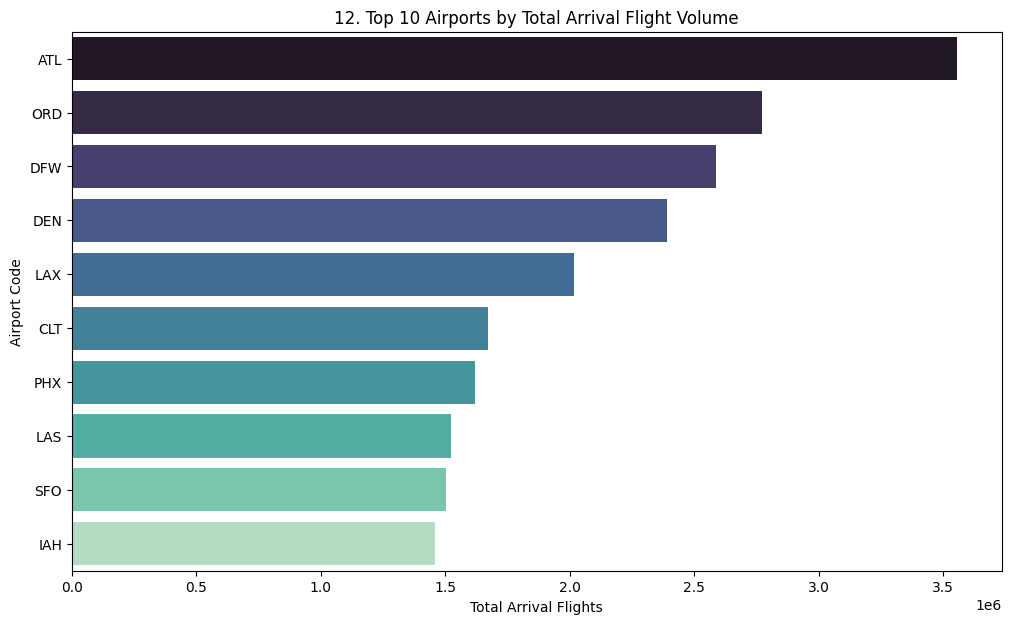

In [ ]:
airport_total_flights = df_processed.groupby('airport')['arr_flights'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=airport_total_flights.values, y=airport_total_flights.index, palette='mako')
plt.title('12. Top 10 Airports by Total Arrival Flight Volume')
plt.xlabel('Total Arrival Flights')
plt.ylabel('Airport Code')
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-33-0ac9796f213d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=carrier_avg_delay.values, y=carrier_avg_delay.index, palette='rocket')


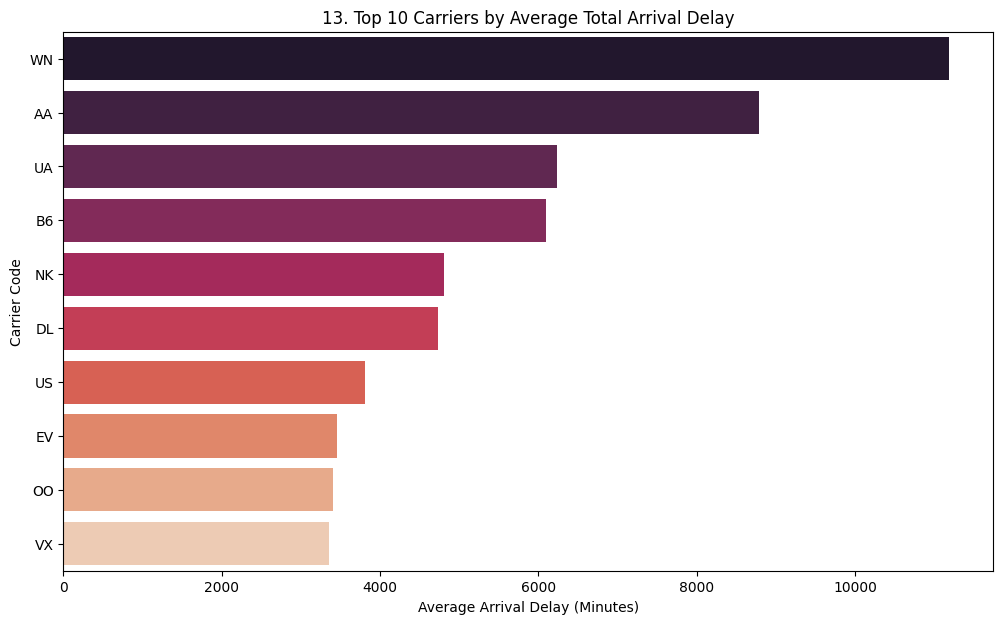

In [ ]:
carrier_avg_delay = df_processed.groupby('carrier')['arr_delay'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=carrier_avg_delay.values, y=carrier_avg_delay.index, palette='rocket')
plt.title('13. Top 10 Carriers by Average Total Arrival Delay')
plt.xlabel('Average Arrival Delay (Minutes)')
plt.ylabel('Carrier Code')
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-34-3b1d25677281>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=carrier_total_flights.values, y=carrier_total_flights.index, palette='viridis')


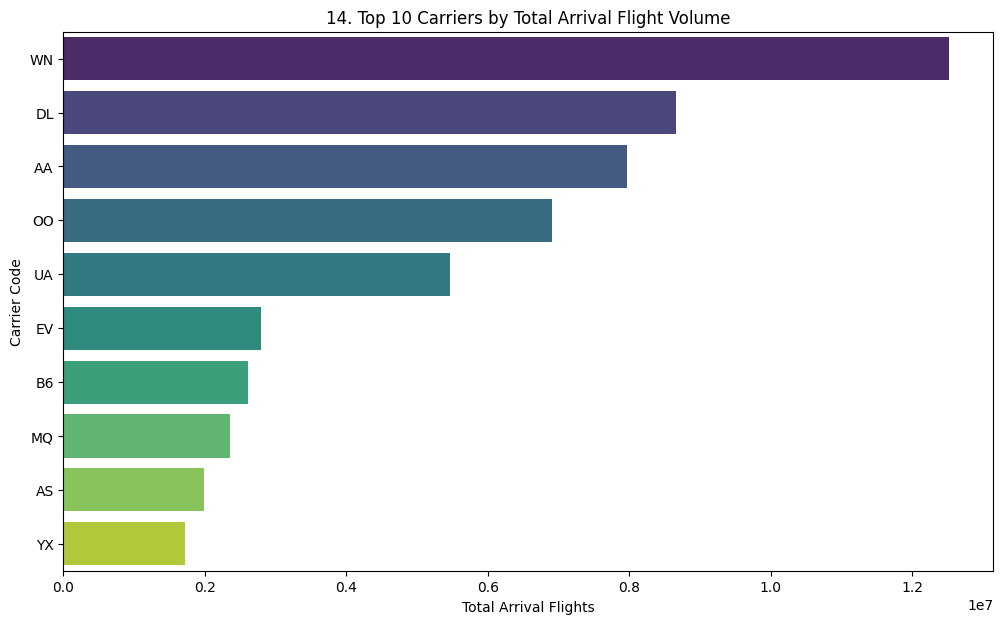

In [ ]:
carrier_total_flights = df_processed.groupby('carrier')['arr_flights'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=carrier_total_flights.values, y=carrier_total_flights.index, palette='viridis')
plt.title('14. Top 10 Carriers by Total Arrival Flight Volume')
plt.xlabel('Total Arrival Flights')
plt.ylabel('Carrier Code')
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-35-4654f14ebb33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=atl_causes.index, y=atl_causes.values, palette='Blues_d')


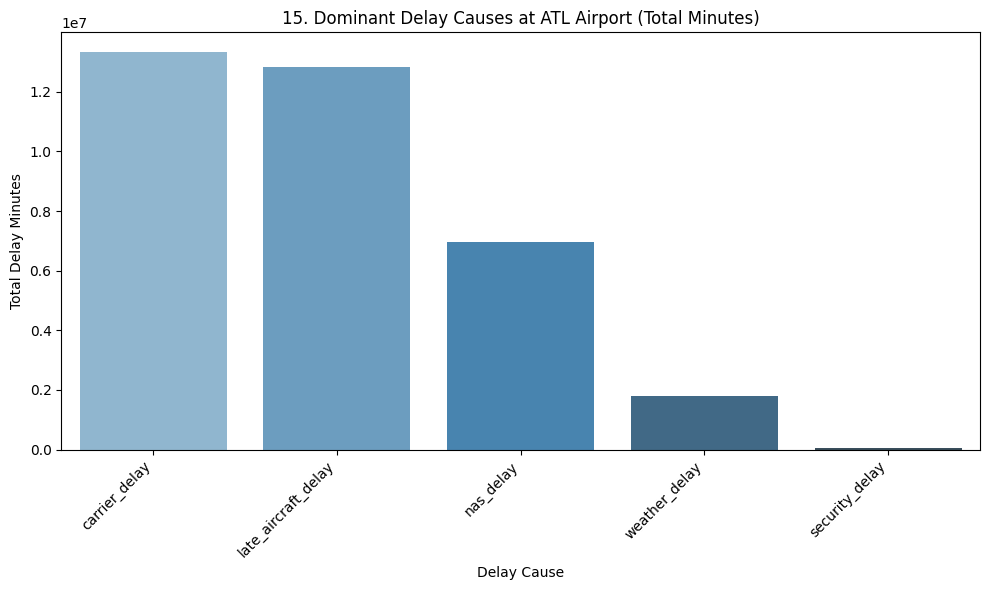

In [ ]:
atl_data = df_processed[df_processed['airport'] == 'ATL']
if not atl_data.empty:
    atl_causes = atl_data[delay_cause_cols].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=atl_causes.index, y=atl_causes.values, palette='Blues_d')
    plt.title('15. Dominant Delay Causes at ATL Airport (Total Minutes)')
    plt.xlabel('Delay Cause')
    plt.ylabel('Total Delay Minutes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("ATL data not found for analysis.")
print("\n" + "="*50 + "\n")

<ipython-input-36-d665e2eeb1f3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aa_causes.index, y=aa_causes.values, palette='Greens_d')


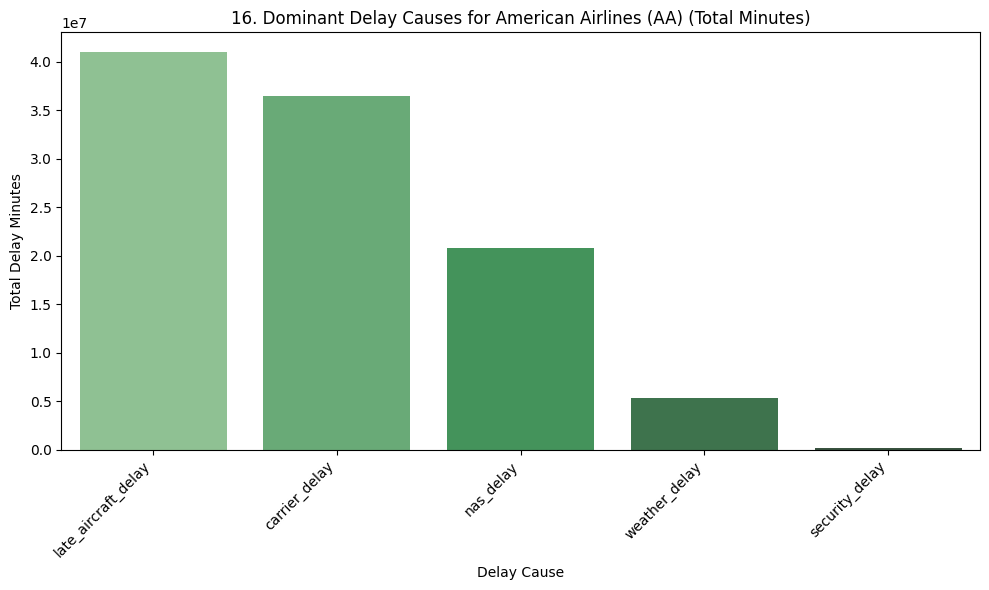

In [ ]:
aa_data = df_processed[df_processed['carrier'] == 'AA']
if not aa_data.empty:
    aa_causes = aa_data[delay_cause_cols].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=aa_causes.index, y=aa_causes.values, palette='Greens_d')
    plt.title('16. Dominant Delay Causes for American Airlines (AA) (Total Minutes)')
    plt.xlabel('Delay Cause')
    plt.ylabel('Total Delay Minutes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("AA data not found for analysis.")
print("\n" + "="*50 + "\n")

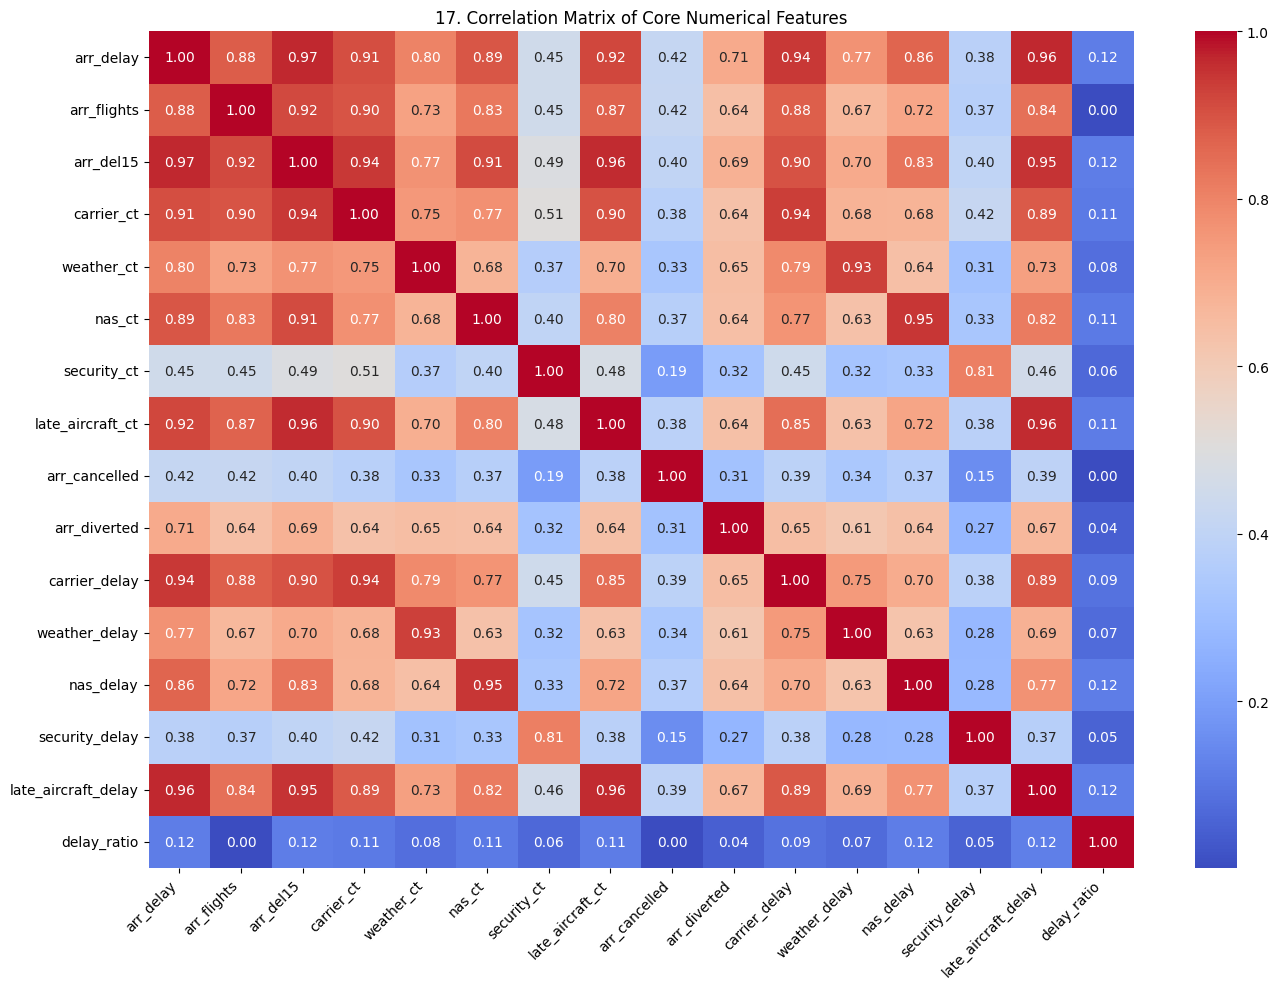

In [ ]:
# Select only numerical columns
numerical_df = df_processed.select_dtypes(include=np.number)
# Exclude year/month from this specific correlation if preferred, or include them.
# Exclude one-hot encoded columns (which are binary and numerous after encoding)
# For simplicity, let's take a subset of core numerical features.
core_numerical_features = [
    'arr_delay', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct',
    'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled',
    'arr_diverted', 'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay', 'delay_ratio'
]
# Ensure selected columns exist
core_numerical_features = [col for col in core_numerical_features if col in numerical_df.columns]

plt.figure(figsize=(14, 10))
sns.heatmap(numerical_df[core_numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('17. Correlation Matrix of Core Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

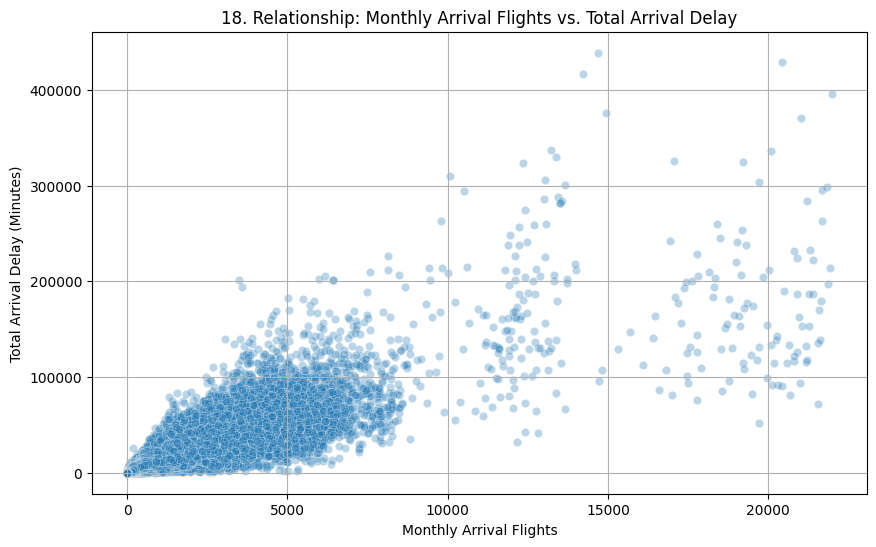

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_processed, x='arr_flights', y='arr_delay', alpha=0.3)
plt.title('18. Relationship: Monthly Arrival Flights vs. Total Arrival Delay')
plt.xlabel('Monthly Arrival Flights')
plt.ylabel('Total Arrival Delay (Minutes)')
plt.grid(True)
plt.show()
print("\n" + "="*50 + "\n")

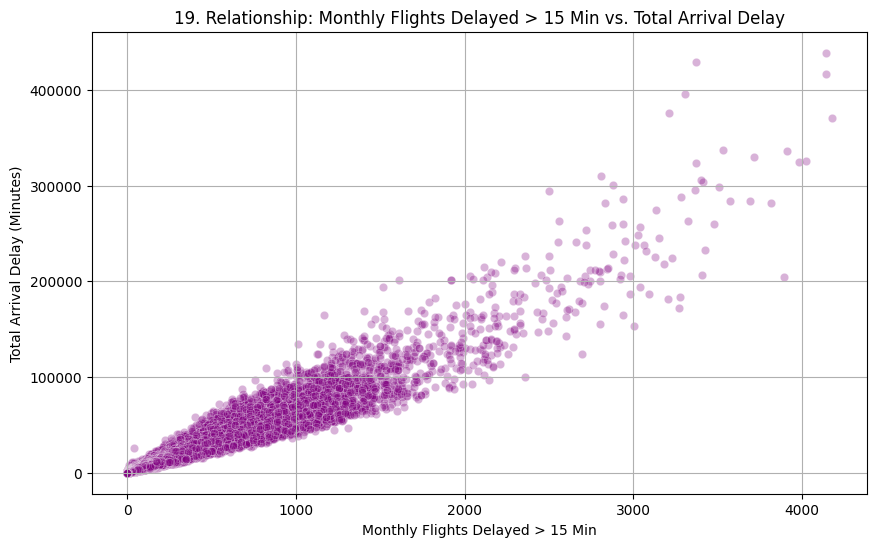

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_processed, x='arr_del15', y='arr_delay', alpha=0.3, color='purple')
plt.title('19. Relationship: Monthly Flights Delayed > 15 Min vs. Total Arrival Delay')
plt.xlabel('Monthly Flights Delayed > 15 Min')
plt.ylabel('Total Arrival Delay (Minutes)')
plt.grid(True)
plt.show()
print("\n" + "="*50 + "\n")

<ipython-input-40-9608a3e55a0c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='has_cancellations', y='arr_delay', data=cancellation_impact, palette='coolwarm')


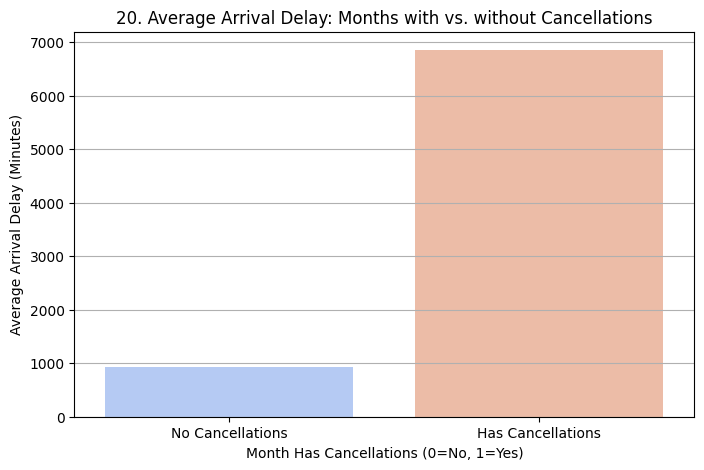

In [ ]:
df_processed['has_cancellations'] = (df_processed['arr_cancelled'] > 0).astype(int)
cancellation_impact = df_processed.groupby('has_cancellations')['arr_delay'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='has_cancellations', y='arr_delay', data=cancellation_impact, palette='coolwarm')
plt.title('20. Average Arrival Delay: Months with vs. without Cancellations')
plt.xlabel('Month Has Cancellations (0=No, 1=Yes)')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.xticks(ticks=[0, 1], labels=['No Cancellations', 'Has Cancellations'])
plt.grid(axis='y')
plt.show()
print("\n" + "="*50 + "\n")